In [1]:
import pandas as pd
import numpy as np
import numpy.ma as ma
from scipy import spatial
from astropy.table import Table
from astropy.cosmology import LambdaCDM as Cos
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from IPython import display 
from scipy import stats
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit, optimize, minimize_scalar, root
import fitsio

import pickle
import dask

## Notes

1. First bin contains 0 galaxies


## To Do:

0. Cross match with redmapper, plot mass completeness

1. Get coordinates of sweeps from csv, plot, see if overlap

2. wget or data transfer

## To do

1. Fit quadratic to approximate area of peak, find peak for each graph, interpolate peaks (try -1*interp1d then minimize scalar or write peakfinder function)

2. To each peak add 0.2 logmass to find the mass completeness point

3. Fit single schechter to values above peak+.2, first only changing phi, then if needed varying Mstar and worst case varying alpha

4. Integrate schechter at each z to find mass, integrate above peak to find mass above peak

5. Interpolate ration of mass/mass above peak as a function of z

## Mask tests

In [6]:
buffer = 0.285
table_of_centers = pd.read_csv("dr9_files.csv")
"""
for i in range(0, len(table_of_centers)):
    table_of_centers.at[i, "patch"] = '/data/mjb299/sweep' + table_of_centers.iloc[i].patch[71:]
    table_of_centers.at[i, "photoz"] = '/data/mjb299/photoz' + table_of_centers.iloc[i].photoz[79:]
    table_of_centers.at[i, "masses"] = '/data/mjb299/mass' + table_of_centers.iloc[i].masses[70:]"""

'\nfor i in range(0, len(table_of_centers)):\n    table_of_centers.at[i, "patch"] = \'/data/mjb299/sweep\' + table_of_centers.iloc[i].patch[71:]\n    table_of_centers.at[i, "photoz"] = \'/data/mjb299/photoz\' + table_of_centers.iloc[i].photoz[79:]\n    table_of_centers.at[i, "masses"] = \'/data/mjb299/mass\' + table_of_centers.iloc[i].masses[70:]'

In [7]:
def data_import(maxx, maxy, minx, miny, row2):
    fits_data = fitsio.FITS(row2.patch)
    sweep = fits_data[1].read(columns=['RELEASE','BRICKID','BRICKNAME', 'OBJID', 'TYPE', 'RA', 'DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'MASKBITS', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_ASTROMETRIC_EXCESS_NOISE'])
    data = Table.read(row2.photoz, format = "fits")
    pz = data.to_pandas()
    #with fits.open(row2.photoz) as data:
    #    pz = pd.DataFrame(data[1].data)
    mass = np.load(row2.masses)
    
    pz['mass'] = mass
    pz['RELEASE']=sweep['RELEASE']
    pz['BRICKID']=sweep['BRICKID']
    pz['BRICKNAME']=sweep['BRICKNAME']
    pz['OBJID']=sweep['OBJID']
    pz['TYPE']=sweep['TYPE']
    pz['RA']=sweep['RA']
    pz['DEC']=sweep['DEC']
    pz['FLUX_G']=sweep['FLUX_G']
    pz['FLUX_R']=sweep['FLUX_R']
    pz['FLUX_Z']=sweep['FLUX_Z']
    pz['FLUX_W1']=sweep['FLUX_W1']
    pz['MASKBITS']=sweep['MASKBITS']
    pz['gaia_phot_g_mean_mag']=sweep['GAIA_PHOT_G_MEAN_MAG']
    pz['gaia_astrometric_excess_noise']=sweep['GAIA_ASTROMETRIC_EXCESS_NOISE']
    pz = pz[np.logical_and.reduce((pz.RA < maxx + buffer/np.cos(pz.DEC*(np.pi/180)), pz.DEC < maxy + buffer, pz.RA > minx - buffer/np.cos(pz.DEC*(np.pi/180)), pz.DEC > miny - buffer))]
    return pz

In [8]:
row = table_of_centers.iloc[0]
fits_data = fitsio.FITS(row.patch)
sweep = fits_data[1].read(columns=['RA', 'DEC'])
maxx = max(sweep['RA'])
maxy = max(sweep['DEC'])
minx = min(sweep['RA'])
miny = min(sweep['DEC'])

maxRA = max(sweep['RA'])
maxDEC = max(sweep['DEC'])
minRA = min(sweep['RA'])
minDEC = min(sweep['DEC'])

ra_dec = data_import(maxx, maxy, minx, miny, row)

In [9]:
len(ra_dec)

6637068

In [10]:
ra_dec["magR"] = 22.5-2.5*np.log10(ra_dec.FLUX_R)
ra_dec["magZ"] = 22.5-2.5*np.log10(ra_dec.FLUX_Z)
ra_dec["magW1"] = 22.5-2.5*np.log10(ra_dec.FLUX_W1)

/global/homes/m/mjyb16/.conda/envs/desi_clusters/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/global/homes/m/mjyb16/.conda/envs/desi_clusters/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


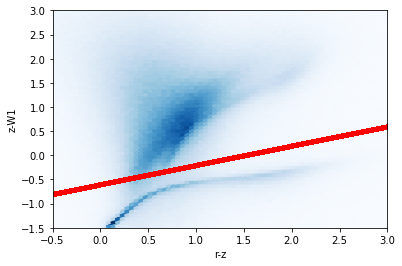

In [11]:
plt.hexbin((ra_dec.magR-ra_dec.magZ), (ra_dec.magZ - ra_dec.magW1), gridsize=(500,500), cmap = "Blues")
plt.plot((ra_dec.magR-ra_dec.magZ), 0.4*(ra_dec.magR-ra_dec.magZ)-0.6, "r.")
plt.xlabel("r-z")
plt.ylabel("z-W1")
plt.ylim(-1.5, 3)
plt.xlim(-0.5, 3)
plt.show()

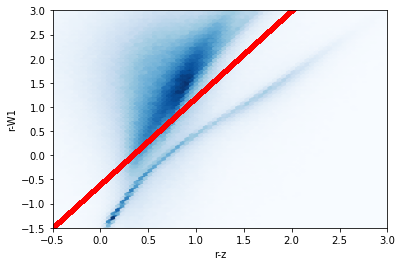

In [12]:
plt.hexbin((ra_dec.magR-ra_dec.magZ), (ra_dec.magR - ra_dec.magW1), gridsize=(500,500), cmap = "Blues")
plt.plot((ra_dec.magR-ra_dec.magZ), 1.8*(ra_dec.magR-ra_dec.magZ)-0.6, "r.")
plt.xlabel("r-z")
plt.ylabel("r-W1")
plt.ylim(-1.5, 3)
plt.xlim(-0.5, 3)
plt.show()

In [13]:
ra_dec = ra_dec[np.logical_or(ra_dec.MASKBITS == 0, ra_dec.MASKBITS == 4096)]
ra_dec = ra_dec[np.logical_or(np.logical_or(ra_dec.gaia_phot_g_mean_mag > 19, ra_dec.gaia_astrometric_excess_noise > 10**.5), ra_dec.gaia_astrometric_excess_noise==0)]
ra_dec = ra_dec[np.logical_and(22.5 - 2.5*np.log10(ra_dec.FLUX_Z)<21, ra_dec.Z_PHOT_MEDIAN>0.01)]
ra_dec = ra_dec[ra_dec.TYPE != "PSF"].copy()

/global/homes/m/mjyb16/.conda/envs/desi_clusters/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/global/homes/m/mjyb16/.conda/envs/desi_clusters/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


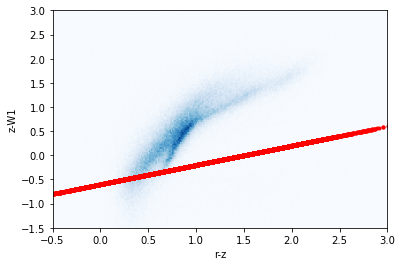

In [14]:
plt.hexbin((ra_dec.magR-ra_dec.magZ), (ra_dec.magZ - ra_dec.magW1), gridsize=(500,500), cmap = "Blues")
plt.plot((ra_dec.magR-ra_dec.magZ), 0.4*(ra_dec.magR-ra_dec.magZ)-0.6, "r.")
plt.xlabel("r-z")
plt.ylabel("z-W1")
plt.ylim(-1.5, 3)
plt.xlim(-0.5, 3)
plt.show()

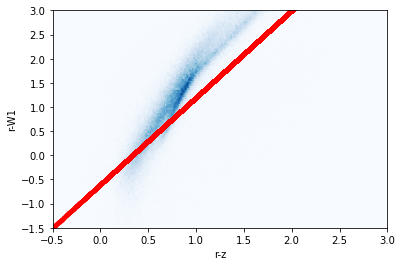

In [15]:
plt.hexbin((ra_dec.magR-ra_dec.magZ), (ra_dec.magR - ra_dec.magW1), gridsize=(500,500), cmap = "Blues")
plt.plot((ra_dec.magR-ra_dec.magZ), 1.8*(ra_dec.magR-ra_dec.magZ)-0.6, "r.")
plt.xlabel("r-z")
plt.ylabel("r-W1")
plt.ylim(-1.5, 3)
plt.xlim(-0.5, 3)
plt.show()

In [16]:
l_mask = (ra_dec.magR - ra_dec.magW1) > 1.8*(ra_dec.magR-ra_dec.magZ)-0.6
l_mask[~np.isfinite(l_mask)] = False
old_mag_mask = np.logical_or(l_mask, ra_dec.magR-ra_dec.magZ < 1)
l2_mask = (ra_dec.magZ - ra_dec.magW1) > 0.4*(ra_dec.magR-ra_dec.magZ)-0.6
l2_mask[~np.isfinite(l2_mask)] = False
new_mag_mask = np.logical_or(l2_mask, ra_dec.magR-ra_dec.magZ < 1.25)
#ra_dec = ra_dec[]
ra_dec_1 = ra_dec[old_mag_mask]
ra_dec_2 = ra_dec[new_mag_mask]



## End Mask Tests

In [17]:
with open("Data/sweep-000m005-010p000_trim.pkl", "rb") as f:
    ra_dec = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'Data/sweep-000m005-010p000_trim.pkl'

In [19]:
ra_dec.columns

Index(['RELEASE', 'BRICKID', 'OBJID', 'Z_PHOT_MEAN', 'Z_PHOT_MEDIAN',
       'Z_PHOT_STD', 'Z_PHOT_L68', 'Z_PHOT_U68', 'Z_PHOT_L95', 'Z_PHOT_U95',
       'Z_SPEC', 'SURVEY', 'TRAINING', 'mass', 'BRICKNAME', 'TYPE', 'RA',
       'DEC', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'MASKBITS',
       'gaia_phot_g_mean_mag', 'gaia_astrometric_excess_noise', 'magR', 'magZ',
       'magW1'],
      dtype='object')

In [21]:
ra_dec.rename(columns = {"Z_PHOT_MEDIAN":"z_phot_median", "Z_PHOT_STD":"z_phot_std"}, inplace = True)

In [22]:
ra_dec = ra_dec[np.logical_or(ra_dec.MASKBITS == 0, ra_dec.MASKBITS == 4096)]
ra_dec = ra_dec[np.logical_or(np.logical_or(ra_dec.gaia_phot_g_mean_mag > 19, ra_dec.gaia_astrometric_excess_noise > 10**.5), ra_dec.gaia_astrometric_excess_noise==0)]

ra_dec["magR"] = 22.5-2.5*np.log10(ra_dec.FLUX_R)
ra_dec["magZ"] = 22.5-2.5*np.log10(ra_dec.FLUX_Z)
ra_dec["magW1"] = 22.5-2.5*np.log10(ra_dec.FLUX_W1)
l_mask = (ra_dec.magR - ra_dec.magW1) > 1.8*(ra_dec.magR-ra_dec.magZ)-0.6
l_mask[~np.isfinite(l_mask)] = False
#ra_dec = ra_dec[l_mask]
#ra_dec = ra_dec[np.logical_or(l_mask, ra_dec.magR-ra_dec.magZ < 1)]
ra_dec = ra_dec[np.logical_and(22.5 - 2.5*np.log10(ra_dec.FLUX_Z)<21, ra_dec.z_phot_median>0.01)]
ra_dec = ra_dec[ra_dec.TYPE != "PSF"].copy()

ra_dec["RA_r"] = (np.pi/180)*ra_dec["RA"]
ra_dec["DEC_r"] = (np.pi/180)*ra_dec["DEC"]
ra_dec["gid"] = list(zip(ra_dec.RA, ra_dec.DEC))

ra_dec.reset_index(inplace = True, drop = True)

oversample = 30
over = np.array([ra_dec.z_phot_median.values]).T*np.ones((len(ra_dec), oversample))
sigma = np.array([ra_dec.z_phot_std.values]).T*np.ones((len(ra_dec), oversample))
random = np.random.normal(loc = 0, scale = 1, size = (len(ra_dec), oversample))
gauss = over + sigma*random
ra_dec["gauss_z"] = pd.Series(list(gauss))

ra_dec["y"] = ra_dec["DEC_r"] - np.mean(ra_dec["DEC_r"]) + 50
ra_dec["x"] = (ra_dec["RA_r"] - np.mean(ra_dec["RA_r"]))*np.cos(ra_dec["DEC_r"]) + 50

/global/homes/m/mjyb16/.conda/envs/desi_clusters/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [23]:
cos = Cos(H0 = 70, Om0 = .286, Ode0 = .714)
z_array = np.linspace(1e-2, ra_dec.z_phot_median.max(), 500)
sparse_radius = (1+z_array)/(cos.comoving_distance(z_array))
radius_threshold = interp1d(z_array, sparse_radius, kind = "linear", fill_value = "extrapolate")

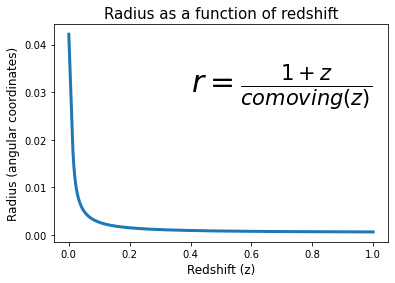

In [24]:
plt.plot(np.linspace(0, 1, 10000), radius_threshold(np.linspace(0, 1, 10000)), "-", lw = 3)
plt.title("Radius as a function of redshift", fontsize = 15)
plt.ylabel("Radius (angular coordinates)", fontsize = 12)
plt.xlabel("Redshift (z)", fontsize = 12)
string = r"$r = \frac{1+z}{comoving(z)}$"
plt.text(0.4, 0.03, s = string, fontsize = 30)
plt.show()

In [25]:
ra_dec.z_phot_median.min()

0.0102697285

In [26]:
radius_threshold(0.014)*180/np.pi

0.980260326337783

In [27]:
median = stats.binned_statistic(ra_dec.z_phot_median, ra_dec.z_phot_std, "median", bins = np.linspace(0.05, ra_dec.z_phot_median.max(), 100))
bins = np.linspace(0.05, ra_dec.z_phot_median.max(), 99)
z_threshold = interp1d(bins, median[0], kind = "linear", fill_value = "extrapolate")

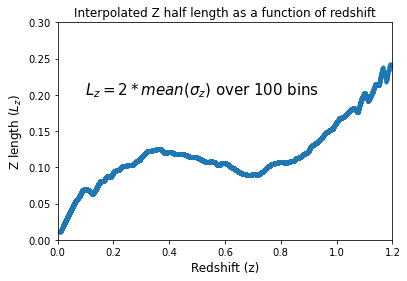

In [28]:
plt.plot(ra_dec.z_phot_median, 2*z_threshold(ra_dec.z_phot_median), ".")
plt.xlim(0, 1.2)
plt.ylim(0, 0.3)
plt.title("Interpolated Z half length as a function of redshift",  fontsize = 12)
plt.ylabel("Z length ($L_z$)",  fontsize = 12)
plt.xlabel("Redshift (z)",  fontsize = 12)
string = r"$L_z = 2* mean(\sigma_z)$ over 100 bins"
plt.text(0.1, 0.2, s = string, fontsize = 15)
plt.show()

In [29]:
massive_sample = ra_dec[ra_dec.mass > 11.2].copy()
massive_sample["neighbor_mass"] = np.zeros(len(massive_sample))
massive_sample["local_neighbor_mass"] = np.zeros(len(massive_sample))
massive_sample["ultra_local_neighbor_mass"] = np.zeros(len(massive_sample))
massive_sample["corrected_neighbor_mass"] = np.zeros(len(massive_sample))
massive_sample["corrected_local_neighbor_mass"] = np.zeros(len(massive_sample))
massive_sample["corrected_ultra_local_neighbor_mass"] = np.zeros(len(massive_sample))
massive_sample["neighbors"] = np.zeros(len(massive_sample))
massive_sample["local_neighbors"] = np.zeros(len(massive_sample))
massive_sample["ultra_local_neighbors"] = np.zeros(len(massive_sample))
massive_sample["neighbor_gids"] = np.zeros(len(massive_sample))
massive_sample["local_neighbor_gids"] = np.zeros(len(massive_sample))
massive_sample["ultra_local_neighbor_gids"] = np.zeros(len(massive_sample))
massive_sample["mass_array"] = np.empty(len(massive_sample), dtype = "object")
massive_sample["weight_array"] = np.empty(len(massive_sample), dtype = "object")
massive_sample["fluxg_array"] = np.empty(len(massive_sample), dtype = "object")
massive_sample["fluxz_array"] = np.empty(len(massive_sample), dtype = "object")
massive_sample["z_array"] = np.empty(len(massive_sample), dtype = "object")
massive_sample.reset_index(inplace=True, drop = True)

In [30]:
tree = spatial.cKDTree(ra_dec[["x", "y"]], copy_data = True)
#tree2 = spatial.cKDTree(gauss[["x", "y"]], copy_data = True)

In [31]:
a = 1.3620186928378857  
b = 9.968545069745126
j= 1.04935943 
k = 0.39573094 
l = 0.28347756
def mass_limit(z):
    return np.minimum((a*z + b), 11.2)

def mass_coefficient(z):
    return np.exp(j*z**2 + k*z + l)

In [32]:
radius = 1
small_radius = 0.5
mini_radius = 0.1

pbar = display.ProgressBar(len(massive_sample)-1)
pbar.display()
indexable = ra_dec[["z_phot_median", "x", "y", "mass", "gauss_z", "FLUX_G", "FLUX_Z"]].values.copy()

iterrator = massive_sample.copy()
for i, row in iterrator.iterrows():
    neighbors = tree.query_ball_point([row.x, row.y], radius_threshold(row.z_phot_median))
    if len(neighbors) > 0:
        local_data = indexable[neighbors]
        
        z_c = z_threshold(row.z_phot_median)
        cylinder = np.abs(np.vstack(local_data[:, 4]) - row.z_phot_median)
        weight_array = cylinder < 2*z_c
        weights = weight_array.sum(axis = 1)/oversample
        
        approx_cluster = np.append(local_data, np.reshape(weights, newshape = (len(weights), 1)), axis = 1)
        cluster = approx_cluster[approx_cluster[:, -1] > 0]
        
        r_smaller = radius_threshold(row.z_phot_median)
        small_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - row.x)**2 + (cluster[:, 2] - row.y)**2).astype(float)) < 0.5*r_smaller]
        mini_cluster = cluster[np.sqrt(np.array((cluster[:, 1] - row.x)**2 + (cluster[:, 2] - row.y)**2).astype(float)) < 0.1*r_smaller]
        
        massive_sample.at[i, "neighbors"] = np.sum(cluster[:, -1])
        massive_sample.at[i, "local_neighbors"] = np.sum(small_cluster[:, -1])
        massive_sample.at[i, "ultra_local_neighbors"] = np.sum(mini_cluster[:, -1])
        
        massive_sample.at[i, "neighbor_mass"] = np.log10(np.sum(np.append((10**cluster[:, 3])*cluster[:, -1], [10**row.mass])))
        c_mask = cluster[:, 3]>mass_limit(row.z_phot_median)
        cluster_limited = cluster[c_mask.astype("bool"), :]
        massive_sample.at[i, "corrected_neighbor_mass"] = np.log10(np.sum(np.append(((10**cluster_limited[:, 3]))*cluster_limited[:, -1], [10**row.mass]))*mass_coefficient(row.z_phot_median))
        massive_sample.at[i, "local_neighbor_mass"] = np.log10(np.sum(np.append((10**small_cluster[:, 3])*small_cluster[:, -1], [10**row.mass])))
        massive_sample.at[i, "ultra_local_neighbor_mass"] = np.log10(np.sum(np.append((10**mini_cluster[:, 3])*mini_cluster[:, -1], [10**row.mass])))
        
        massive_sample.at[i, "mass_array"] = np.log10(np.append((10**cluster[:, 3]), [10**row.mass]).astype(float))
        massive_sample.at[i, "weight_array"] = np.append(cluster[:, -1], [1])
        massive_sample.at[i, "fluxg_array"] = np.append(cluster[:, 5], [row.FLUX_G])
        massive_sample.at[i, "fluxz_array"] = np.append(cluster[:, 6], [row.FLUX_Z])
        massive_sample.at[i, "z_array"] = np.append(cluster[:, 0], [row.z_phot_median])
        
    
    pbar.progress = i

[============================================================] 29938/29938

In [33]:
bins = np.arange(0.05, massive_sample.z_phot_median.max(), 0.01)
binned = [massive_sample[np.logical_and(massive_sample.z_phot_median>=i-.025, massive_sample.z_phot_median<=i+.025)].copy() for i in bins]
clusters = pd.DataFrame()
threshold1 = np.empty(len(binned))
threshold2 = np.empty(len(binned))
for i in range(len(binned)):
    threshold1[i] = np.mean(binned[i].neighbors) + 1.8*np.sqrt(np.mean(binned[i].neighbors))
    threshold2[i] = np.mean(binned[i].local_neighbors) + 1.2*np.sqrt(np.mean(binned[i].local_neighbors))

In [34]:
thresh1 = interp1d(bins, threshold1, kind = "linear", fill_value = "extrapolate")
thresh2 = interp1d(bins, threshold2, kind = "linear", fill_value = "extrapolate")

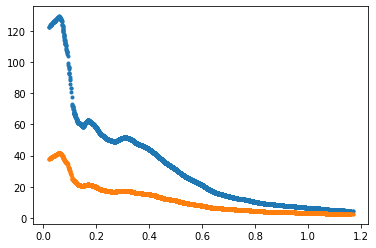

In [35]:
graph1 = thresh1(massive_sample.z_phot_median)
graph2 = thresh2(massive_sample.z_phot_median)
plt.plot(massive_sample.z_phot_median, graph1, ".")
plt.plot(massive_sample.z_phot_median, graph2, ".")
plt.show()

In [36]:
clusters = massive_sample[np.logical_and(massive_sample.neighbors >= thresh1(massive_sample.z_phot_median), massive_sample.local_neighbors >= thresh2(massive_sample.z_phot_median))].copy()

In [37]:
len(clusters)

2075

In [38]:
clusters.sort_values("local_neighbor_mass", inplace = True, ascending = False)
clusters.reset_index(inplace= True, drop = True)

In [39]:
tree = spatial.cKDTree(clusters[["x", "y"]], copy_data = True)

In [40]:
pbar = display.ProgressBar(len(clusters)-1)
pbar.display()
clusters["ncluster"] = np.zeros(len(clusters))
clusternum = 1

iterrator = clusters.copy()
for i, row in iterrator.iterrows():
    if clusters.iloc[i].ncluster == 0:
        clusters.at[i, "ncluster"] = clusternum
        neighbors = tree.query_ball_point([row.x, row.y], 1.5*radius_threshold(row.z_phot_median))
        for index in neighbors:
            if clusters.at[index, "ncluster"] == 0 and np.abs(clusters.at[index, "z_phot_median"] - row.z_phot_median) < 2*z_threshold(row.z_phot_median):
                clusters.at[index, "ncluster"] = clusternum
            
        clusternum += 1
    
    pbar.progress = i

[============================================================] 2074/2074

In [41]:
cluster_center = clusters.sort_values(by = ['ncluster','ultra_local_neighbor_mass'], ascending = [True, False]).groupby('ncluster').head(1).copy()
len(cluster_center)

817

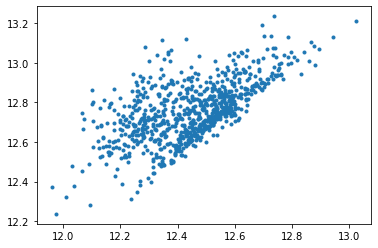

In [42]:
plt.plot(cluster_center.neighbor_mass, cluster_center.corrected_neighbor_mass, ".")
plt.show()

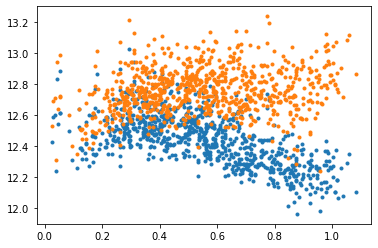

In [43]:
plt.plot(cluster_center.z_phot_median, cluster_center.neighbor_mass, ".")
plt.plot(cluster_center.z_phot_median, cluster_center.corrected_neighbor_mass, ".")
plt.show()

<ipython-input-44-1e986f378aa3>:7: RuntimeWarning: invalid value encountered in log10
  graph_frame_unlimited["gmz"] = (22.5-2.5*np.log10(graph_frame_unlimited.fluxG.values.astype(float))) - (22.5-2.5*np.log10(graph_frame_unlimited.fluxZ.values.astype(float)))


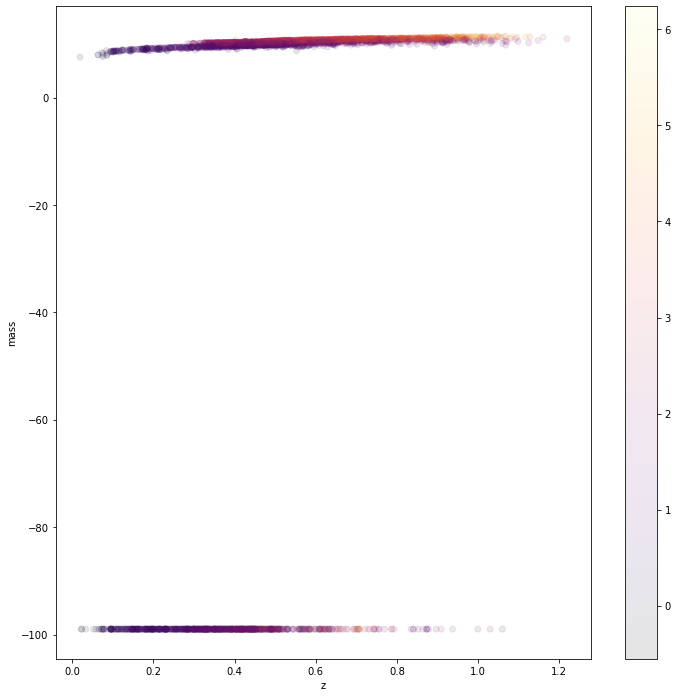

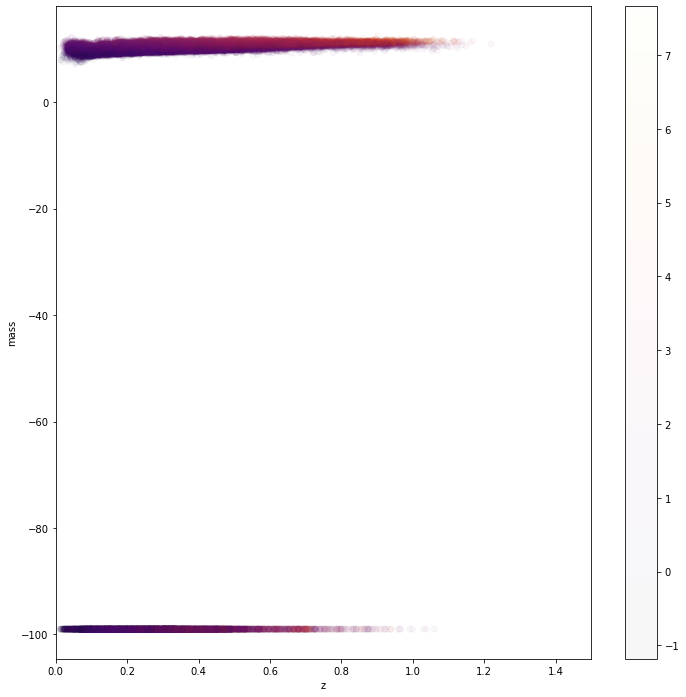

In [44]:
fluxZ = np.concatenate(cluster_center.fluxz_array.values.flatten())
fluxG = np.concatenate(cluster_center.fluxg_array.values.flatten())
mass_concat = np.concatenate(cluster_center.mass_array.values.flatten())
z_concat = np.concatenate(cluster_center.z_array.values.flatten())

graph_frame_unlimited = pd.DataFrame(np.array([fluxZ, fluxG, mass_concat, z_concat]).T, columns = ["fluxZ", "fluxG", "mass", "z"])
graph_frame_unlimited["gmz"] = (22.5-2.5*np.log10(graph_frame_unlimited.fluxG.values.astype(float))) - (22.5-2.5*np.log10(graph_frame_unlimited.fluxZ.values.astype(float)))
graph_frame = graph_frame_unlimited[22.5-2.5*np.log10(graph_frame_unlimited.fluxZ.values.astype(float)) > 20.9].copy()

plt.figure(figsize = (12, 12))
plt.scatter(graph_frame.z, graph_frame.mass, c = graph_frame.gmz, cmap = "inferno", alpha = 0.1)
plt.colorbar()
plt.xlabel("z")
plt.ylabel("mass")
plt.show()

plt.figure(figsize = (12, 12))
plt.scatter(graph_frame_unlimited.z, graph_frame_unlimited.mass, c = graph_frame_unlimited.gmz, cmap = "inferno", alpha = 0.03)
plt.colorbar()
plt.xlim(0, 1.5)
plt.xlabel("z")
plt.ylabel("mass")
plt.show()

In [45]:
cluster_center.head(1).T

,0
RELEASE,9010
BRICKID,204281
OBJID,2127
Z_PHOT_MEAN,0.296181
z_phot_median,0.293494
z_phot_std,0.013743
Z_PHOT_L68,0.285586
Z_PHOT_U68,0.309258
Z_PHOT_L95,0.273583
Z_PHOT_U95,0.32596


In [46]:
#Subtracting mass background from cluster_center
cluster_center["neighbor_mass"] = np.log10(10**cluster_center["neighbor_mass"] - 10**mass_back(cluster_center.z_phot_median))

NameError: name 'mass_back' is not defined

In [47]:
bins_z = np.linspace(0.025, 1.025, 22)

In [48]:
binned = [cluster_center[np.logical_and(cluster_center.z_phot_median>=i-.025, cluster_center.z_phot_median<=i+0.025)].mass_array.copy() for i in bins_z]
binned2 = [cluster_center[np.logical_and(cluster_center.z_phot_median>=i-.025, cluster_center.z_phot_median<=i+0.025)].weight_array.copy() for i in bins_z]

In [49]:
mass_list = []
for clusters in binned:
    if len(clusters) > 0:
        mass_list += [np.concatenate(clusters.values.flatten())]
    else:
        mass_list += []
    
weight_list = []
for clusters in binned2:
    if len(clusters) > 0:
        weight_list += [np.concatenate(clusters.values.flatten()).astype(float)]
    else:
        weight_list += []

In [50]:
def schechter(m, mstar, alpha, phi):
    return (m/mstar)**alpha * np.e**(-m/mstar) * (phi/mstar)
def d_schechter(m, mstar, alpha1, alpha2, phi1, phi2):
    return (phi1*(m/mstar)**alpha1 + phi2*(m/mstar)**alpha2) * np.e**(-m/mstar)/mstar
a = 1.3620186928378857  
b = 9.968545069745126
def mass_limit(z):
    return np.minimum((a*z + b), 11.2)

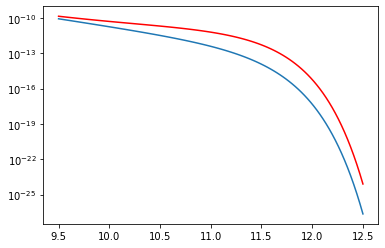

'm = np.linspace(9.5, 12.5, 100)\nplt.semilogy(m, d_chechter(10**m, 10.83e10, -1.46, -.21), "-")\nplt.show()\nm = np.linspace(9.5, 12.5, 100)\nplt.semilogy(m, schechter(10**m, 10.75e10, -0.07, ), "-")\nplt.show()'

In [51]:
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, schechter(10**m, 10.83e10, -1.3, 0.098), "-")
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, d_schechter(10**m, 10.83e10, -1.3, -0.39, 0.098, 1.58), "-r")
plt.show()
"""m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, d_chechter(10**m, 10.83e10, -1.46, -.21), "-")
plt.show()
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, schechter(10**m, 10.75e10, -0.07, ), "-")
plt.show()"""

In [52]:
np.log10(popt[0])

NameError: name 'popt' is not defined

[ 1.10450665e+11 -4.58821575e-01  1.66316640e+00]


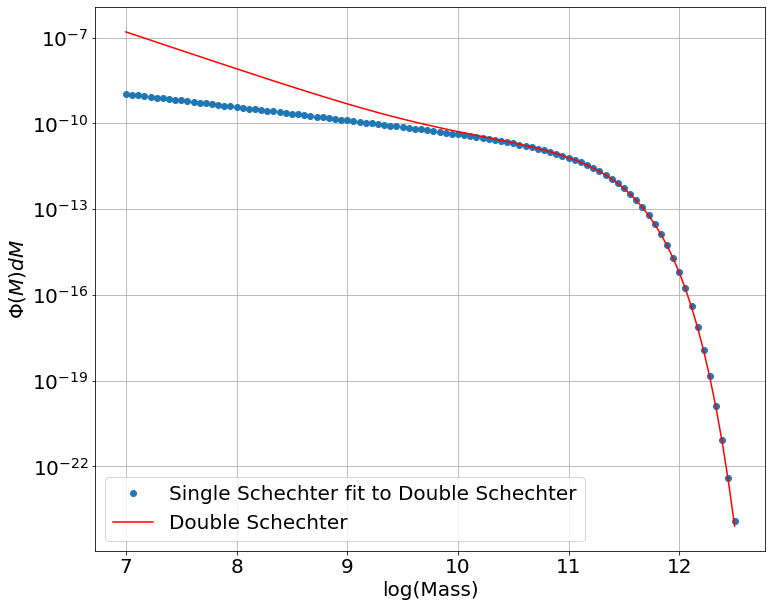

In [53]:
m = np.linspace(11, 12.5, 1000)
data = d_schechter(10**m, 10.83e10, -1.3, -0.39, 0.098, 1.58)
popt, pcov = curve_fit(schechter, 10**m, data, p0 = (10e10, -1, 1))
print(popt)
m = np.linspace(7, 12.5, 100)
plt.figure(figsize = (12, 10))
plt.semilogy(m, schechter(10**m, *popt), "o", label = "Single Schechter fit to Double Schechter")
plt.semilogy(m, d_schechter(10**m, 10.83e10, -1.3, -0.39, 0.098, 1.58), "-r", label = "Double Schechter")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("log(Mass)", fontsize = 20)
plt.ylabel("$\Phi(M)dM$", fontsize = 20)
plt.grid()
plt.legend(fontsize = 20, loc = "lower left")
plt.savefig("schechter.pdf")
plt.show()

[ 6.83006859e+10 -4.40103665e-01  1.66548272e+03]


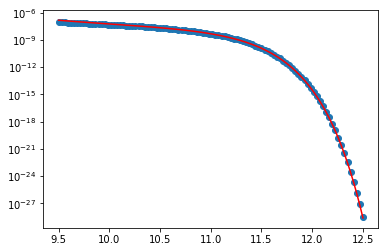

In [54]:
m = np.linspace(11, 12.5, 1000)
data = d_schechter(10**m, 10**10.83, -1.3, -0.39, 0.098*10**3, 1.58*10**3)
popt, pcov = curve_fit(schechter, 10**m, data, p0 = (10e10, -1, 1))
print(popt)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, schechter(10**m, *popt), "o")
plt.semilogy(m, d_schechter(10**m, 10**10.83, -1.3, -0.39, 0.098*10**3, 1.58*10**3), "-r")
plt.show()

## Adams vs COSMOS2020

In [ ]:
#COSMOS2020
#0.2<z<0.5
mstar = 10**10.97
alpha1 = -0.75
phi1 = 79.53*10**-5
alpha2 = -2.04
phi2 = 0.18*10**-5
#0.5<z<0.8
mstar = 10**10.90
alpha1 = -0.50
phi1 = 92.06*10**-5
alpha2 = -2.14
phi2 = 0.09*10**-5
#0.8<z<1.1
mstar = 10**10.87 
alpha1 = -0.44 
phi1 = 102.63*10**-5 
alpha2 = -2.14 
phi2 = 0.07*10**-5

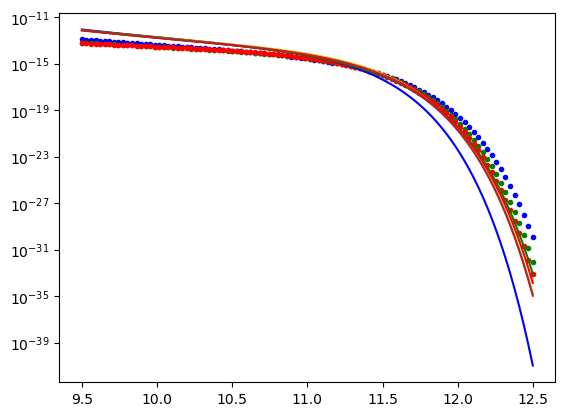

In [184]:
m = np.linspace(9.5, 12.5, 100)

#COSMOS2020
#0.2<z<0.5
mstar = 10**10.97
alpha1 = -0.75
phi1 = 79.53*10**-5
alpha2 = -2.04
phi2 = 0.18*10**-5
plt.semilogy(m, d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2), ".b")

#0.5<z<0.8
mstar = 10**10.90
alpha1 = -0.50
phi1 = 92.06*10**-5
alpha2 = -2.14
phi2 = 0.09*10**-5
plt.semilogy(m, d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2), ".g")

#0.8<z<1.1
mstar = 10**10.87 
alpha1 = -0.44 
phi1 = 102.63*10**-5 
alpha2 = -2.14 
phi2 = 0.07*10**-5
plt.semilogy(m, d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2), ".r")

#Adams
#0.1<z<0.2
mstar = 10**10.71 
alpha1 = -0.47 
phi1 = 10**-2.61 
alpha2 = -1.60 
phi2 = 10**-3.34
plt.semilogy(m, d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2), "blue")

#0.2<z<0.3
mstar = 10**10.89 
alpha1 = -1.06 
phi1 = 10**-2.76 
alpha2 = -1.57 
phi2 = 10**-4.12
plt.semilogy(m, d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2), "green")

#0.3<z<0.5
mstar = 10**10.83 
alpha1 = -0.64 
phi1 = 10**-2.60 
alpha2 = -1.61 
phi2 = 10**-3.62
plt.semilogy(m, d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2), "orange")

#0.5<z<0.75
mstar = 10**10.86 
alpha1 = -0.80 
phi1 = 10**-2.71 
alpha2 = -1.69 
phi2 = 10**-3.78
plt.semilogy(m, d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2), "red")

#0.75<z<1
mstar = 10**10.83 
alpha1 = -0.67 
phi1 = 10**-2.68 
alpha2 = -1.67 
phi2 = 10**-3.63
plt.semilogy(m, d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2), "brown")

plt.show()

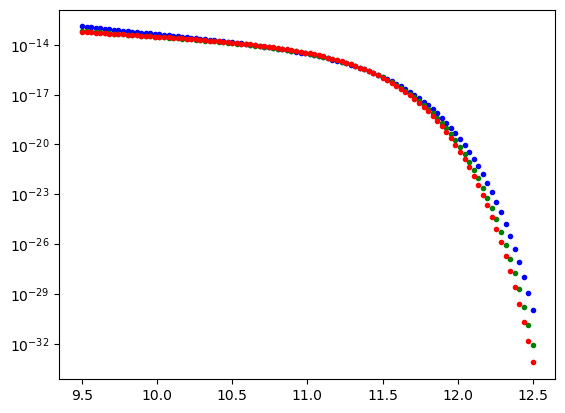

In [183]:
m = np.linspace(9.5, 12.5, 100)

#COSMOS2020
#0.2<z<0.5
mstar = 10**10.97
alpha1 = -0.75
phi1 = 79.53*10**-5
alpha2 = -2.04
phi2 = 0.18*10**-5
plt.semilogy(m, d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2), ".b")

#0.5<z<0.8
mstar = 10**10.90
alpha1 = -0.50
phi1 = 92.06*10**-5
alpha2 = -2.14
phi2 = 0.09*10**-5
plt.semilogy(m, d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2), ".g")

#0.8<z<1.1
mstar = 10**10.87 
alpha1 = -0.44 
phi1 = 102.63*10**-5 
alpha2 = -2.14 
phi2 = 0.07*10**-5
plt.semilogy(m, d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2), ".r")

plt.show()

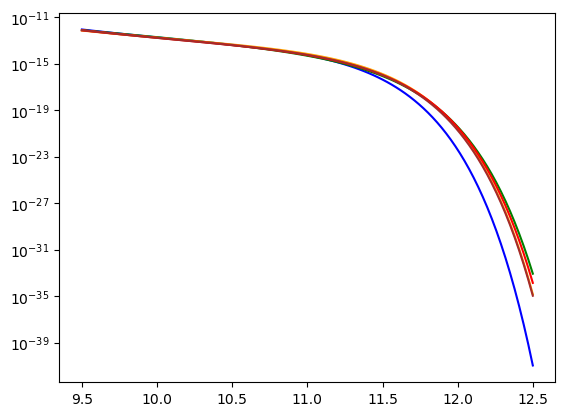

In [180]:
m = np.linspace(9.5, 12.5, 100)

#Adams
#0.1<z<0.2
mstar = 10**10.71 
alpha1 = -0.47 
phi1 = 10**-2.61 
alpha2 = -1.60 
phi2 = 10**-3.34
plt.semilogy(m, d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2), "blue")

#0.2<z<0.3
mstar = 10**10.89 
alpha1 = -1.06 
phi1 = 10**-2.76 
alpha2 = -1.57 
phi2 = 10**-4.12
plt.semilogy(m, d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2), "green")

#0.3<z<0.5
mstar = 10**10.83 
alpha1 = -0.64 
phi1 = 10**-2.60 
alpha2 = -1.61 
phi2 = 10**-3.62
plt.semilogy(m, d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2), "orange")

#0.5<z<0.75
mstar = 10**10.86 
alpha1 = -0.80 
phi1 = 10**-2.71 
alpha2 = -1.69 
phi2 = 10**-3.78
plt.semilogy(m, d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2), "red")

#0.75<z<1
mstar = 10**10.83 
alpha1 = -0.67 
phi1 = 10**-2.68 
alpha2 = -1.67 
phi2 = 10**-3.63
plt.semilogy(m, d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2), "brown")

plt.show()

In [ ]:
#Adams
#0.1<z<0.2
mstar = 10**10.71 
alpha1 = -0.47 
phi1 = 10**-2.61 
alpha2 = -1.60 
phi2 = 10**-3.34
#0.2<z<0.3
mstar = 10**10.89 
alpha1 = -1.06 
phi1 = 10**-2.76 
alpha2 = -1.57 
phi2 = 10**-4.12
#0.3<z<0.5
mstar = 10**10.83 
alpha1 = -0.64 
phi1 = 10**-2.60 
alpha2 = -1.61 
phi2 = 10**-3.62
#0.5<z<0.75
mstar = 10**10.86 
alpha1 = -0.80 
phi1 = 10**-2.71 
alpha2 = -1.69 
phi2 = 10**-3.78
#0.75<z<1
mstar = 10**10.83 
alpha1 = -0.67 
phi1 = 10**-2.68 
alpha2 = -1.67 
phi2 = 10**-3.63

## Fitting single schechters to double schechters from COSMOS2020

[ 9.34295052e+10 -7.53498308e-01  7.96389937e-04]


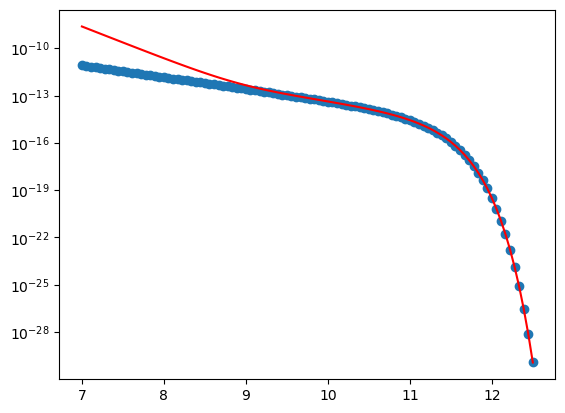

In [186]:
#Z 0.2-0.5
m = np.linspace(11, 12.5, 1000)
mstar = 10**10.97
alpha1 = -0.75
phi1 = 79.53*10**-5
alpha2 = -2.04
phi2 = 0.18*10**-5

data = d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2)
popt, pcov = curve_fit(schechter, 10**m, data, p0 = (10e10, -1, 1))
print(popt)
m = np.linspace(7, 12.5, 100)
plt.semilogy(m, schechter(10**m, *popt), "o")
plt.semilogy(m, d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2), "-r")
plt.show()

[ 7.94684283e+10 -5.01475038e-01  9.21206125e-04]


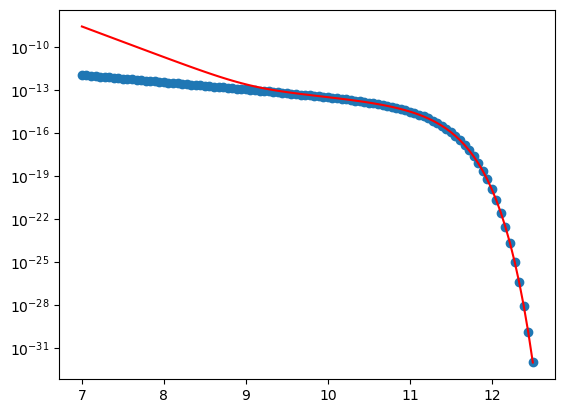

In [187]:
#Z 0.5-0.8
m = np.linspace(11, 12.5, 1000)
mstar = 10**10.90
alpha1 = -0.50
phi1 = 92.06*10**-5
alpha2 = -2.14
phi2 = 0.09*10**-5

data = d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2)
popt, pcov = curve_fit(schechter, 10**m, data, p0 = (10e10, -1, 1))
print(popt)
m = np.linspace(7, 12.5, 100)
plt.semilogy(m, schechter(10**m, *popt), "o")
plt.semilogy(m, d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2), "-r")
plt.show()

[ 7.41515244e+10 -4.40950237e-01  1.02678182e-03]


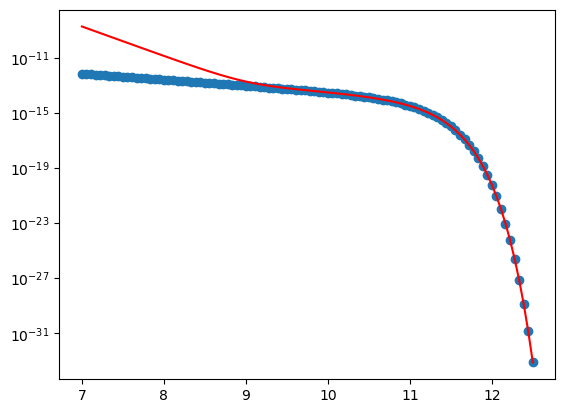

In [188]:
#Z 0.8-1.1
m = np.linspace(11, 12.5, 1000)
mstar = 10**10.87 
alpha1 = -0.44 
phi1 = 102.63*10**-5 
alpha2 = -2.14 
phi2 = 0.07*10**-5

data = d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2)
popt, pcov = curve_fit(schechter, 10**m, data, p0 = (10e10, -1, 1))
print(popt)
m = np.linspace(7, 12.5, 100)
plt.semilogy(m, schechter(10**m, *popt), "o")
plt.semilogy(m, d_schechter(10**m, mstar, alpha1, alpha2, phi1, phi2), "-r")
plt.show()

/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  """Entry point for launching an IPython kernel.


ValueError: A value in x_new is below the interpolation range.

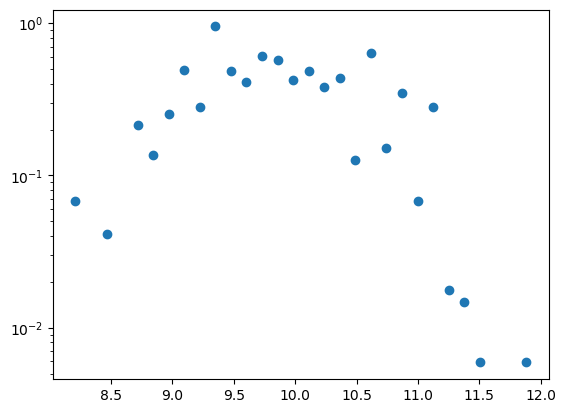

In [51]:
hist = np.histogram(mass_list[0], weights = weight_list[0], bins= 30, normed = True)
obs_schechter = 0
obs_schechter = UnivariateSpline(hist[1][20:30], hist[0][20:30], bbox = [7, 12.5])
obs_schechter = interp1d(hist[1][20:30], hist[0][20:30])
plt.semilogy(hist[1][0:-1], hist[0], "o")
plt.semilogy(m, obs_schechter(m), "-")
plt.show()
plt.plot(m, np.gradient(np.log(obs_schechter(m))), "-")
plt.show()

In [ ]:
plt.plot(m, np.log(obs_schechter(m)), "-")
plt.show()
obs_grad = interp1d(np.linspace(9, 13, 20), np.gradient(np.log(obs_schechter(np.linspace(9, 13, 20)))), kind = "linear", fill_value = "extrapolate")
plt.plot(m, np.abs(obs_grad(m)), "-")
plt.show()

In [184]:
root(obs_grad, x0 = 11)

    fjac: array([[-1.]])
     fun: array([1.69309011e-15])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 17
     qtf: array([-1.69309011e-15])
       r: array([0.])
  status: 5
 success: False
       x: array([10.76083897])

In [406]:
np.linspace(7, 13, 26)

array([ 7.  ,  7.24,  7.48,  7.72,  7.96,  8.2 ,  8.44,  8.68,  8.92,
        9.16,  9.4 ,  9.64,  9.88, 10.12, 10.36, 10.6 , 10.84, 11.08,
       11.32, 11.56, 11.8 , 12.04, 12.28, 12.52, 12.76, 13.  ])

In [55]:
peak_list = np.zeros(22)

[9.81751427 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


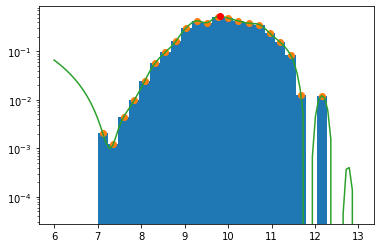

In [56]:
n, bins, _ = plt.hist(mass_list[0], weights = weight_list[0], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[0] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[9.81751427 9.99284992 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


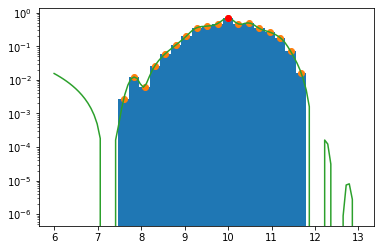

In [57]:
n, bins, _ = plt.hist(mass_list[1], weights = weight_list[1], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[1] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[ 9.81751427  9.99284992 10.24879939  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


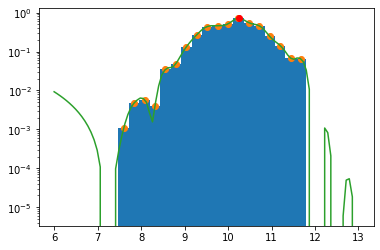

In [58]:
n, bins, _ = plt.hist(mass_list[2], weights = weight_list[2], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[2] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[ 9.81751427  9.99284992 10.24879939 10.31509494  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


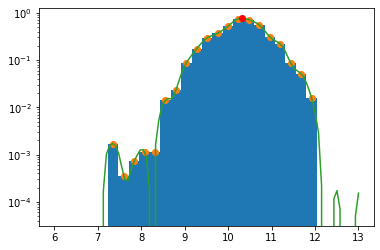

In [59]:
n, bins, _ = plt.hist(mass_list[3], weights = weight_list[3], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[3] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[ 9.81751427  9.99284992 10.24879939 10.31509494 10.53675473  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


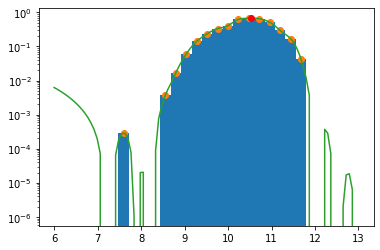

In [60]:
n, bins, _ = plt.hist(mass_list[4], weights = weight_list[4], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[4] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[ 9.81751427  9.99284992 10.24879939 10.31509494 10.53675473 10.48327636
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


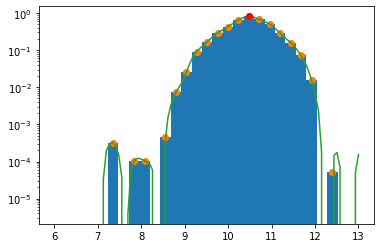

In [61]:
n, bins, _ = plt.hist(mass_list[5], weights = weight_list[5], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[5] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[ 9.81751427  9.99284992 10.24879939 10.31509494 10.53675473 10.48327636
 10.50814596  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


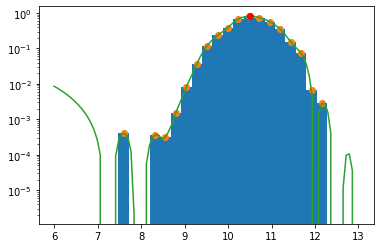

In [62]:
n, bins, _ = plt.hist(mass_list[6], weights = weight_list[6], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[6] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[ 9.81751427  9.99284992 10.24879939 10.31509494 10.53675473 10.48327636
 10.50814596 10.51461599  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


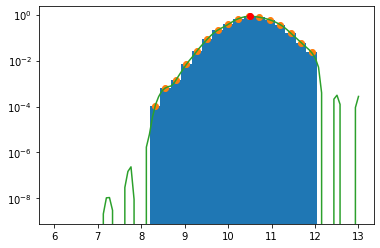

In [63]:
n, bins, _ = plt.hist(mass_list[7], weights = weight_list[7], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[7] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[ 9.81751427  9.99284992 10.24879939 10.31509494 10.53675473 10.48327636
 10.50814596 10.51461599 10.52313913  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


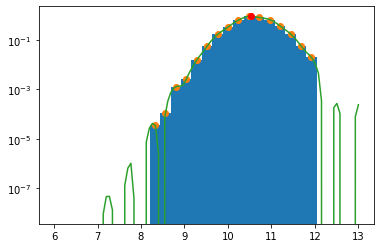

In [64]:
n, bins, _ = plt.hist(mass_list[8], weights = weight_list[8], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[8] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[ 9.81751427  9.99284992 10.24879939 10.31509494 10.53675473 10.48327636
 10.50814596 10.51461599 10.52313913 10.5805532   0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


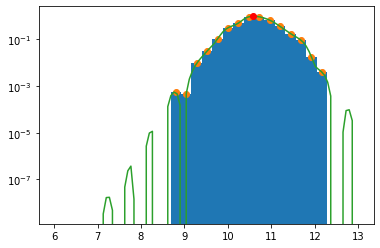

In [65]:
n, bins, _ = plt.hist(mass_list[9], weights = weight_list[9], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[9] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[ 9.81751427  9.99284992 10.24879939 10.31509494 10.53675473 10.48327636
 10.50814596 10.51461599 10.52313913 10.5805532  10.72437575  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


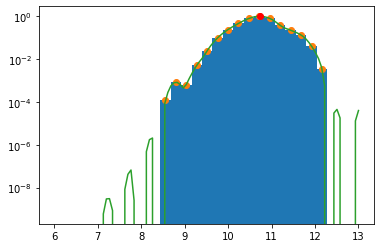

In [66]:
n, bins, _ = plt.hist(mass_list[10], weights = weight_list[10], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[10] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[ 9.81751427  9.99284992 10.24879939 10.31509494 10.53675473 10.48327636
 10.50814596 10.51461599 10.52313913 10.5805532  10.72437575 10.79320227
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


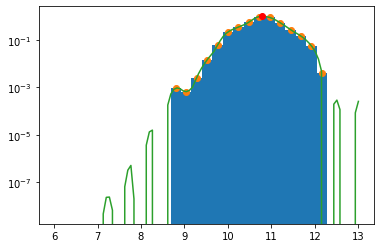

In [67]:
n, bins, _ = plt.hist(mass_list[11], weights = weight_list[11], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[11] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[ 9.81751427  9.99284992 10.24879939 10.31509494 10.53675473 10.48327636
 10.50814596 10.51461599 10.52313913 10.5805532  10.72437575 10.79320227
 10.87179987  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ]


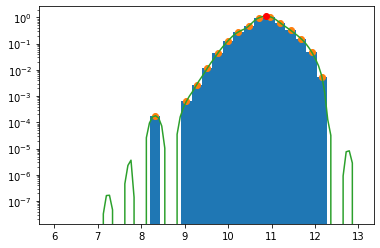

In [68]:
n, bins, _ = plt.hist(mass_list[12], weights = weight_list[12], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[12] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[ 9.81751427  9.99284992 10.24879939 10.31509494 10.53675473 10.48327636
 10.50814596 10.51461599 10.52313913 10.5805532  10.72437575 10.79320227
 10.87179987 10.9475312   0.          0.          0.          0.
  0.          0.          0.          0.        ]


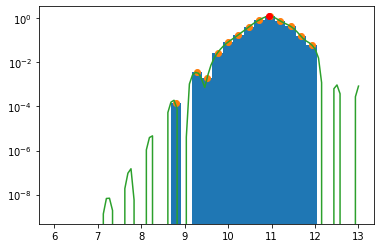

In [69]:
n, bins, _ = plt.hist(mass_list[13], weights = weight_list[13], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[13] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[ 9.81751427  9.99284992 10.24879939 10.31509494 10.53675473 10.48327636
 10.50814596 10.51461599 10.52313913 10.5805532  10.72437575 10.79320227
 10.87179987 10.9475312  10.99765704  0.          0.          0.
  0.          0.          0.          0.        ]


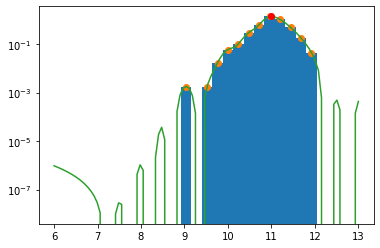

In [70]:
n, bins, _ = plt.hist(mass_list[14], weights = weight_list[14], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[14] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[ 9.81751427  9.99284992 10.24879939 10.31509494 10.53675473 10.48327636
 10.50814596 10.51461599 10.52313913 10.5805532  10.72437575 10.79320227
 10.87179987 10.9475312  10.99765704 11.01425314  0.          0.
  0.          0.          0.          0.        ]


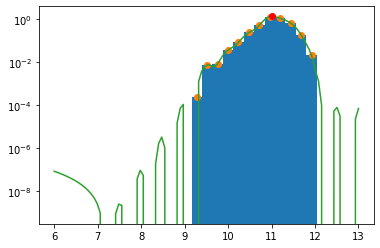

In [71]:
n, bins, _ = plt.hist(mass_list[15], weights = weight_list[15], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[15] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[ 9.81751427  9.99284992 10.24879939 10.31509494 10.53675473 10.48327636
 10.50814596 10.51461599 10.52313913 10.5805532  10.72437575 10.79320227
 10.87179987 10.9475312  10.99765704 11.01425314 11.0764862   0.
  0.          0.          0.          0.        ]


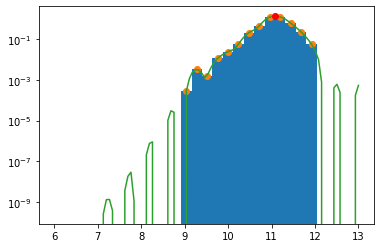

In [72]:
n, bins, _ = plt.hist(mass_list[16], weights = weight_list[16], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[16] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[ 9.81751427  9.99284992 10.24879939 10.31509494 10.53675473 10.48327636
 10.50814596 10.51461599 10.52313913 10.5805532  10.72437575 10.79320227
 10.87179987 10.9475312  10.99765704 11.01425314 11.0764862  11.17508875
  0.          0.          0.          0.        ]


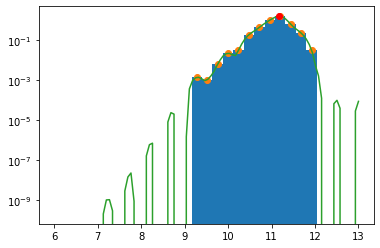

In [73]:
n, bins, _ = plt.hist(mass_list[17], weights = weight_list[17], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[17] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[ 9.81751427  9.99284992 10.24879939 10.31509494 10.53675473 10.48327636
 10.50814596 10.51461599 10.52313913 10.5805532  10.72437575 10.79320227
 10.87179987 10.9475312  10.99765704 11.01425314 11.0764862  11.17508875
 11.21967235  0.          0.          0.        ]


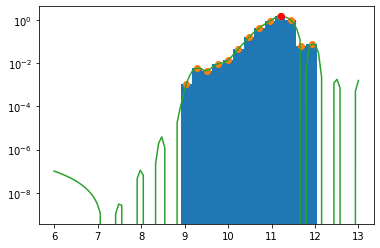

In [74]:
n, bins, _ = plt.hist(mass_list[18], weights = weight_list[18], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[18] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[ 9.81751427  9.99284992 10.24879939 10.31509494 10.53675473 10.48327636
 10.50814596 10.51461599 10.52313913 10.5805532  10.72437575 10.79320227
 10.87179987 10.9475312  10.99765704 11.01425314 11.0764862  11.17508875
 11.21967235 11.24515497  0.          0.        ]


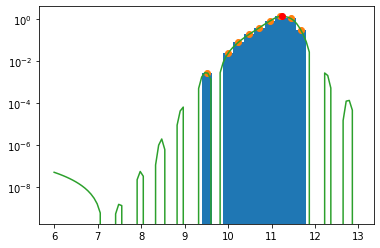

In [75]:
n, bins, _ = plt.hist(mass_list[19], weights = weight_list[19], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[19] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

[ 9.81751427  9.99284992 10.24879939 10.31509494 10.53675473 10.48327636
 10.50814596 10.51461599 10.52313913 10.5805532  10.72437575 10.79320227
 10.87179987 10.9475312  10.99765704 11.01425314 11.0764862  11.17508875
 11.21967235 11.24515497 11.38297023  0.        ]


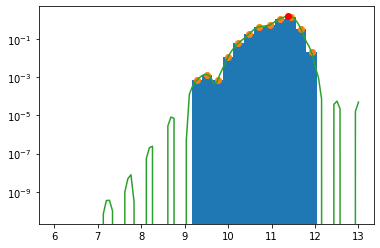

In [76]:
n, bins, _ = plt.hist(mass_list[20], weights = weight_list[20], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
plt.plot(peaks[1], peaks[0], "o")
peakfinder = interp1d(peaks[1], -1*peaks[0], kind = "quadratic", fill_value = "extrapolate")
m_list = np.linspace(6, 13, 100)
plt.plot(m_list, -1*peakfinder(m_list))

m_peak = minimize_scalar(peakfinder, method = "bounded", bounds = [9, 13])
peak_list[20] = m_peak.x
print(peak_list)
plt.plot(m_peak.x, -1*peakfinder(m_peak.x), "or")
plt.show()

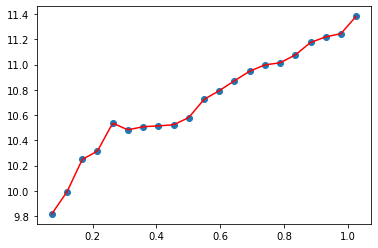

In [77]:
plt.plot(bins_z[1:], peak_list[0:-1], "o")
mass_lim = interp1d(bins_z[1:], peak_list[0:-1], kind = "linear", fill_value = "extrapolate")
z_test = np.linspace(bins_z[1], bins_z[-1], 100)
plt.plot(z_test, mass_lim(z_test), "-r")
plt.show()

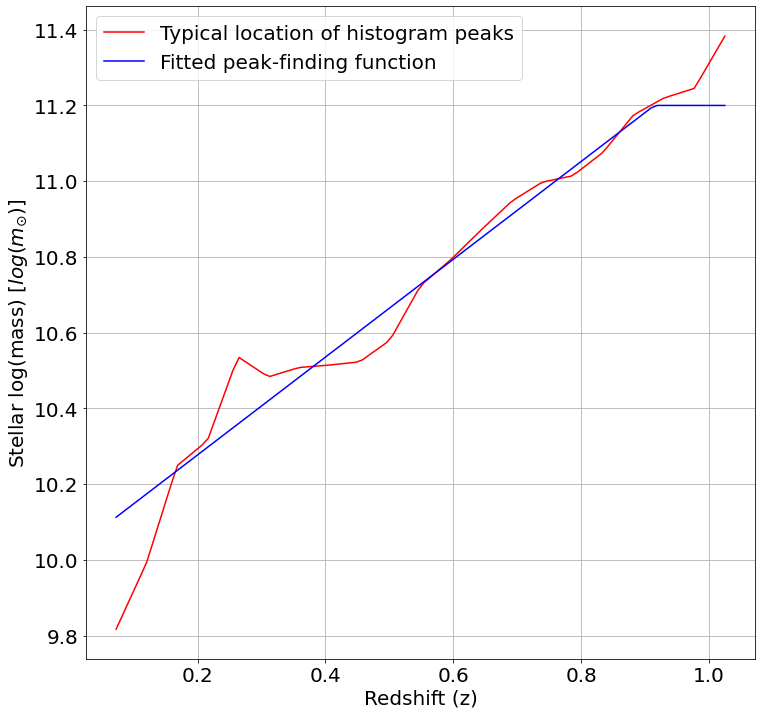

In [83]:
plt.figure(figsize = (12, 12))
plt.plot(z_test, mass_lim(z_test), "-r", label = "Typical location of histogram peaks")
a, b = np.polyfit(z_test[4:], mass_lim(z_test[4:]), deg = 1)
#plt.plot(z_test, a*z_test + b)
plt.plot(z_test, mass_limit(z_test), "-b", label = "Fitted peak-finding function")
#print(a, b)
plt.legend(fontsize = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel("Redshift (z)",fontsize = 20)
plt.ylabel("Stellar log(mass) [$log(m_{\odot})$]",fontsize = 20)
plt.grid()
plt.savefig('peaks.pdf')
plt.show()

In [76]:
[ 1.10450665e+11 -4.58821575e-01  1.66316640e+00]

SyntaxError: invalid syntax (3819291489.py, line 1)

In [84]:
def schechter_fit(m, logphi, logmstar):
    phi = 10**logphi
    mstar = 10**logmstar
    return (m/mstar)**-4.58821575e-01 * np.e**(-m/mstar) * (phi/mstar)

In [174]:
# COSMOS2015 schechter functions, may not even be accurately fitted(!)
#def schechter_fit_1(m, logphi, logmstar):
#    phi = 10**logphi
#    mstar = 10**logmstar
#    return np.log10((m/mstar)**-4.58821575e-01 * np.e**(-m/mstar) * (phi/mstar))
#def schechter_fit_2(m, logphi, logmstar):
#    phi = 10**logphi
#    mstar = 10**logmstar
#    return np.log10((m/mstar)**-2.23512236e-01 * np.e**(-m/mstar) * (phi/mstar))
#def schechter_fit_3(m, logphi, logmstar):
#    phi = 10**logphi
#    mstar = 10**logmstar
#    return np.log10((m/mstar)**-0.07 * np.e**(-m/mstar) * (phi/mstar))

In [85]:
# COSMOS2020 schechter functions
def schechter_fit_1(m, logphi, logmstar):
    phi = 10**logphi
    mstar = 10**logmstar
    return np.log10((m/mstar)**-7.53498308e-01 * np.e**(-m/mstar) * (phi/mstar))
def schechter_fit_2(m, logphi, logmstar):
    phi = 10**logphi
    mstar = 10**logmstar
    return np.log10((m/mstar)**-5.01475038e-01 * np.e**(-m/mstar) * (phi/mstar))
def schechter_fit_3(m, logphi, logmstar):
    phi = 10**logphi
    mstar = 10**logmstar
    return np.log10((m/mstar)**-4.40950237e-01 * np.e**(-m/mstar) * (phi/mstar))

In [86]:
phi_mstar = np.empty(22, dtype = "object")

In [87]:
np.log10((2.9e10, 2.90e+11))

array([10.462398, 11.462398])

<ipython-input-88-0259782facad>:6: RuntimeWarning: divide by zero encountered in log10
  popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))


[10.6543833  11.46254773]
[array([10.6543833 , 11.46254773]) None None None None None None None None
 None None None None None None None None None None None None None]


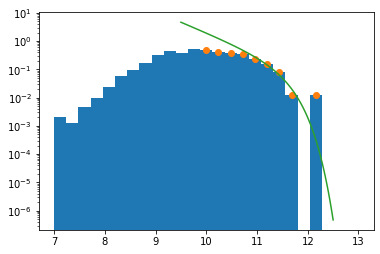

In [88]:
n, bins, _ = plt.hist(mass_list[0], weights = weight_list[0], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[1])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")

popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[0] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_1(10**m, *popt), "-")
plt.show()

<ipython-input-89-c6f0c9577ad9>:6: RuntimeWarning: divide by zero encountered in log10
  popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))


[10.5104139  11.46254773]
[array([10.6543833 , 11.46254773]) array([10.5104139 , 11.46254773]) None
 None None None None None None None None None None None None None None
 None None None None None]


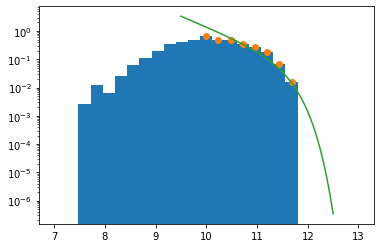

In [89]:
n, bins, _ = plt.hist(mass_list[1], weights = weight_list[1], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[2])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")

popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[1] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_1(10**m, *popt), "-")
plt.show()

<ipython-input-90-f1ad4b3edcc4>:6: RuntimeWarning: divide by zero encountered in log10
  popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))


[10.7094233  11.46254773]
[array([10.6543833 , 11.46254773]) array([10.5104139 , 11.46254773])
 array([10.7094233 , 11.46254773]) None None None None None None None None
 None None None None None None None None None None None]


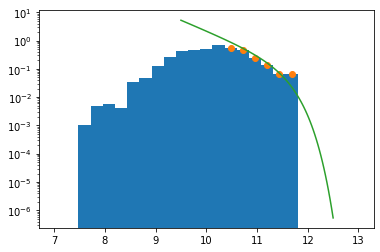

In [90]:
n, bins, _ = plt.hist(mass_list[2], weights = weight_list[2], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[3])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")

popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[2] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_1(10**m, *popt), "-")
plt.show()

<ipython-input-100-01201bd15253>:7: RuntimeWarning: divide by zero encountered in log10
  popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))


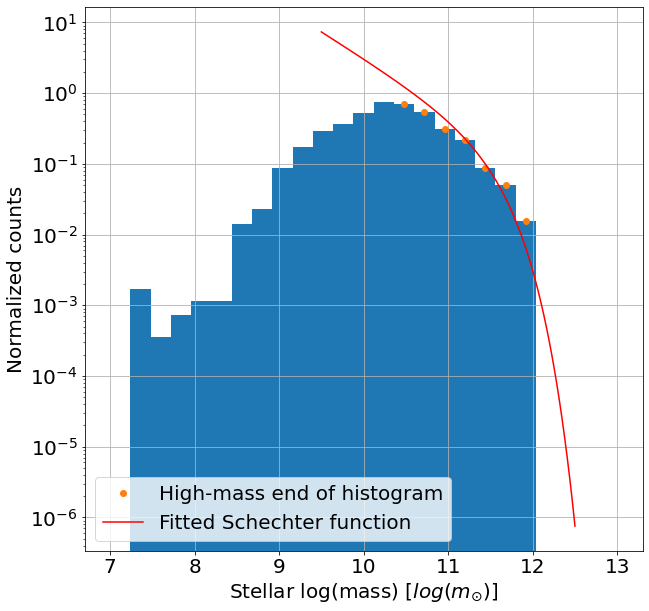

In [100]:
plt.figure(figsize = (10, 10))
n, bins, _ = plt.hist(mass_list[3], weights = weight_list[3], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[4])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o", label = "High-mass end of histogram")

popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
#print(popt)
phi_mstar[3] = popt
#print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)

plt.semilogy(m, 10**schechter_fit_1(10**m, *popt), "-r", label = "Fitted Schechter function")
plt.legend(fontsize = 20, loc = "lower left")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel("Normalized counts",fontsize = 20)
plt.xlabel("Stellar log(mass) [$log(m_{\odot})$]",fontsize = 20)
plt.grid()
plt.savefig('fit.pdf')
plt.show()

<ipython-input-96-1d1bb15597bf>:6: RuntimeWarning: divide by zero encountered in log10
  popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))


[10.94934919 11.46254773]
[array([10.6543833 , 11.46254773]) array([10.5104139 , 11.46254773])
 array([10.7094233 , 11.46254773]) array([10.85494587, 11.46254773])
 array([10.94934919, 11.46254773]) None None None None None None None None
 None None None None None None None None None]


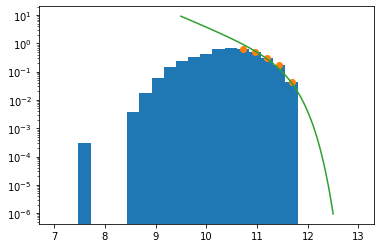

In [96]:
n, bins, _ = plt.hist(mass_list[4], weights = weight_list[4], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[5])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")

popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[4] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_1(10**m, *popt), "-")
plt.show()

<ipython-input-97-bf099360ac64>:6: RuntimeWarning: divide by zero encountered in log10
  popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))


[11.11833063 11.46254773]
[array([10.6543833 , 11.46254773]) array([10.5104139 , 11.46254773])
 array([10.7094233 , 11.46254773]) array([10.85494587, 11.46254773])
 array([10.94934919, 11.46254773]) array([11.11833063, 11.46254773]) None
 None None None None None None None None None None None None None None
 None]


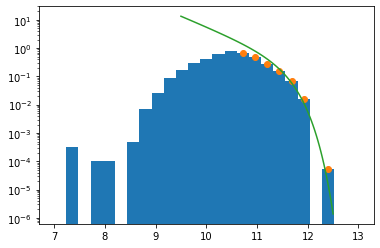

In [97]:
n, bins, _ = plt.hist(mass_list[5], weights = weight_list[5], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[6])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")

popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[5] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_1(10**m, *popt), "-")
plt.show()

<ipython-input-98-59e4eef673ce>:6: RuntimeWarning: divide by zero encountered in log10
  popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))


[11.0858394  11.46254773]
[array([10.6543833 , 11.46254773]) array([10.5104139 , 11.46254773])
 array([10.7094233 , 11.46254773]) array([10.85494587, 11.46254773])
 array([10.94934919, 11.46254773]) array([11.11833063, 11.46254773])
 array([11.0858394 , 11.46254773]) None None None None None None None None
 None None None None None None None]


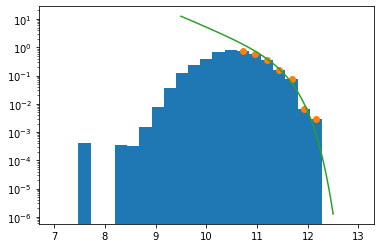

In [98]:
n, bins, _ = plt.hist(mass_list[6], weights = weight_list[6], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[7])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")

popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[6] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_1(10**m, *popt), "-")
plt.show()

<ipython-input-101-d43ee58823cc>:6: RuntimeWarning: divide by zero encountered in log10
  popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))


[11.08448482 11.46254773]
[array([10.6543833 , 11.46254773]) array([10.5104139 , 11.46254773])
 array([10.7094233 , 11.46254773]) array([10.85494587, 11.46254773])
 array([10.94934919, 11.46254773]) array([11.11833063, 11.46254773])
 array([11.0858394 , 11.46254773]) array([11.08448482, 11.46254773]) None
 None None None None None None None None None None None None None]


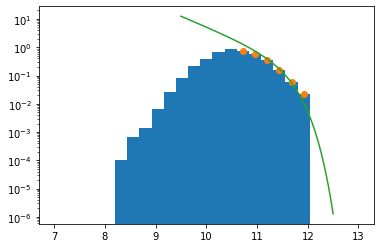

In [101]:
n, bins, _ = plt.hist(mass_list[7], weights = weight_list[7], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[8])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")

popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[7] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_1(10**m, *popt), "-")
plt.show()

<ipython-input-102-4e108f83b6e9>:6: RuntimeWarning: divide by zero encountered in log10
  popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))


[11.08760667 11.46254773]
[array([10.6543833 , 11.46254773]) array([10.5104139 , 11.46254773])
 array([10.7094233 , 11.46254773]) array([10.85494587, 11.46254773])
 array([10.94934919, 11.46254773]) array([11.11833063, 11.46254773])
 array([11.0858394 , 11.46254773]) array([11.08448482, 11.46254773])
 array([11.08760667, 11.46254773]) None None None None None None None None
 None None None None None]


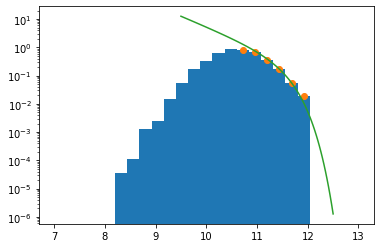

In [102]:
n, bins, _ = plt.hist(mass_list[8], weights = weight_list[8], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[9])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")

popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[8] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_1(10**m, *popt), "-")
plt.show()

<ipython-input-103-d1b198b2a139>:6: RuntimeWarning: divide by zero encountered in log10
  popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))


[11.22083516 11.46254773]
[array([10.6543833 , 11.46254773]) array([10.5104139 , 11.46254773])
 array([10.7094233 , 11.46254773]) array([10.85494587, 11.46254773])
 array([10.94934919, 11.46254773]) array([11.11833063, 11.46254773])
 array([11.0858394 , 11.46254773]) array([11.08448482, 11.46254773])
 array([11.08760667, 11.46254773]) array([11.22083516, 11.46254773]) None
 None None None None None None None None None None None]


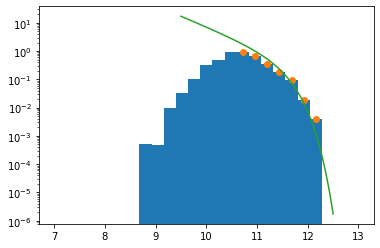

In [103]:
n, bins, _ = plt.hist(mass_list[9], weights = weight_list[9], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[10])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")

popt, pcov = curve_fit(schechter_fit_1, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[9] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_1(10**m, *popt), "-")
plt.show()

<ipython-input-104-a3775f7bae6e>:6: RuntimeWarning: divide by zero encountered in log10
  popt, pcov = curve_fit(schechter_fit_2, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))


[11.34524425 11.46254773]
[array([10.6543833 , 11.46254773]) array([10.5104139 , 11.46254773])
 array([10.7094233 , 11.46254773]) array([10.85494587, 11.46254773])
 array([10.94934919, 11.46254773]) array([11.11833063, 11.46254773])
 array([11.0858394 , 11.46254773]) array([11.08448482, 11.46254773])
 array([11.08760667, 11.46254773]) array([11.22083516, 11.46254773])
 array([11.34524425, 11.46254773]) None None None None None None None None
 None None None]


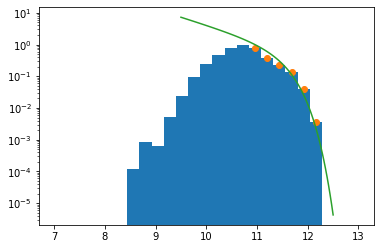

In [104]:
n, bins, _ = plt.hist(mass_list[10], weights = weight_list[10], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[11])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")

popt, pcov = curve_fit(schechter_fit_2, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[10] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_2(10**m, *popt), "-")
plt.show()

<ipython-input-105-aaae0f510a08>:6: RuntimeWarning: divide by zero encountered in log10
  popt, pcov = curve_fit(schechter_fit_2, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))


[11.4417197  11.46254773]
[array([10.6543833 , 11.46254773]) array([10.5104139 , 11.46254773])
 array([10.7094233 , 11.46254773]) array([10.85494587, 11.46254773])
 array([10.94934919, 11.46254773]) array([11.11833063, 11.46254773])
 array([11.0858394 , 11.46254773]) array([11.08448482, 11.46254773])
 array([11.08760667, 11.46254773]) array([11.22083516, 11.46254773])
 array([11.34524425, 11.46254773]) array([11.4417197 , 11.46254773]) None
 None None None None None None None None None]


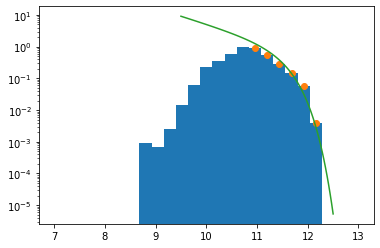

In [105]:
n, bins, _ = plt.hist(mass_list[11], weights = weight_list[11], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[12])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")

popt, pcov = curve_fit(schechter_fit_2, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[11] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_2(10**m, *popt), "-")
plt.show()

<ipython-input-106-b8f7e831a9f9>:6: RuntimeWarning: divide by zero encountered in log10
  popt, pcov = curve_fit(schechter_fit_2, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))


[11.48822974 11.46254773]
[array([10.6543833 , 11.46254773]) array([10.5104139 , 11.46254773])
 array([10.7094233 , 11.46254773]) array([10.85494587, 11.46254773])
 array([10.94934919, 11.46254773]) array([11.11833063, 11.46254773])
 array([11.0858394 , 11.46254773]) array([11.08448482, 11.46254773])
 array([11.08760667, 11.46254773]) array([11.22083516, 11.46254773])
 array([11.34524425, 11.46254773]) array([11.4417197 , 11.46254773])
 array([11.48822974, 11.46254773]) None None None None None None None None
 None]


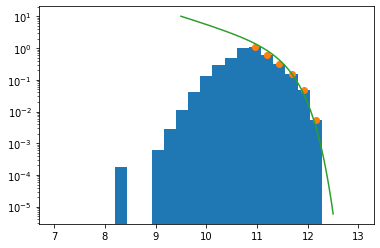

In [106]:
n, bins, _ = plt.hist(mass_list[12], weights = weight_list[12], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[13])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")

popt, pcov = curve_fit(schechter_fit_2, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[12] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_2(10**m, *popt), "-")
plt.show()

<ipython-input-109-9639d1d75101>:7: RuntimeWarning: divide by zero encountered in log10
  popt, pcov = curve_fit(schechter_fit_2, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))


[11.51593382 11.46254773]
[array([10.6543833 , 11.46254773]) array([10.5104139 , 11.46254773])
 array([10.7094233 , 11.46254773]) array([10.85494587, 11.46254773])
 array([10.94934919, 11.46254773]) array([11.11833063, 11.46254773])
 array([11.0858394 , 11.46254773]) array([11.08448482, 11.46254773])
 array([11.08760667, 11.46254773]) array([11.22083516, 11.46254773])
 array([11.34524425, 11.46254773]) array([11.4417197 , 11.46254773])
 array([11.48822974, 11.46254773]) array([11.51593382, 11.46254773]) None
 None None None None None None None]


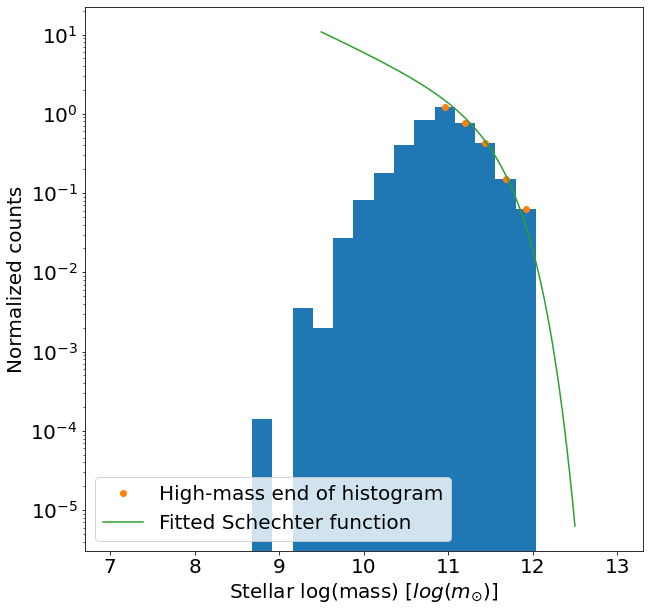

In [109]:
plt.figure(figsize = (10, 10))
n, bins, _ = plt.hist(mass_list[13], weights = weight_list[13], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[14])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o", label = "High-mass end of histogram")

popt, pcov = curve_fit(schechter_fit_2, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[13] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_2(10**m, *popt), "-", label = "Fitted Schechter function")
plt.legend(fontsize = 20, loc = "lower left")
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel("Normalized counts",fontsize = 20)
plt.xlabel("Stellar log(mass) [$log(m_{\odot})$]",fontsize = 20)
#plt.grid()
plt.savefig('fit.pdf')
plt.show()

/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


[11.60912616 11.46254773]
[array([10.24217541, 11.46254773]) array([10.5582347 , 11.46254773])
 array([10.31209011, 11.462398  ]) array([10.76445975, 11.46254771])
 array([10.99107627, 11.46254773]) array([10.8974015 , 11.46254773])
 array([10.97125284, 11.46254773]) array([11.00170981, 11.46254773])
 array([11.19086503, 11.46254773]) array([11.2117798 , 11.46254773])
 array([11.29026067, 11.46254773]) array([11.37592114, 11.46254773])
 array([11.40453165, 11.46254772]) array([11.50395787, 11.46254771])
 array([11.60912616, 11.46254773]) None None None None None None None]


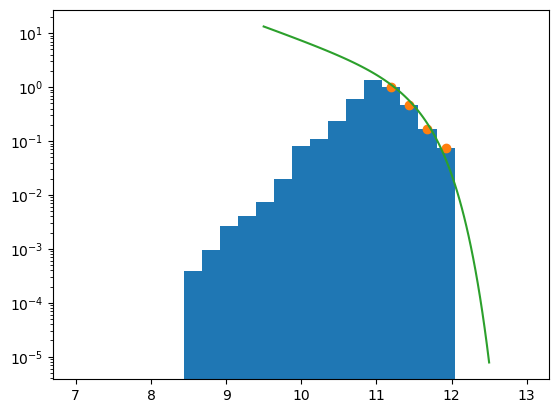

In [209]:
n, bins, _ = plt.hist(mass_list[14], weights = weight_list[14], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[15])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")

popt, pcov = curve_fit(schechter_fit_2, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[14] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_2(10**m, *popt), "-")
plt.show()

/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


[11.62735961 11.46254773]
[array([10.24217541, 11.46254773]) array([10.5582347 , 11.46254773])
 array([10.31209011, 11.462398  ]) array([10.76445975, 11.46254771])
 array([10.99107627, 11.46254773]) array([10.8974015 , 11.46254773])
 array([10.97125284, 11.46254773]) array([11.00170981, 11.46254773])
 array([11.19086503, 11.46254773]) array([11.2117798 , 11.46254773])
 array([11.29026067, 11.46254773]) array([11.37592114, 11.46254773])
 array([11.40453165, 11.46254772]) array([11.50395787, 11.46254771])
 array([11.60912616, 11.46254773]) array([11.62735961, 11.46254773]) None
 None None None None None]


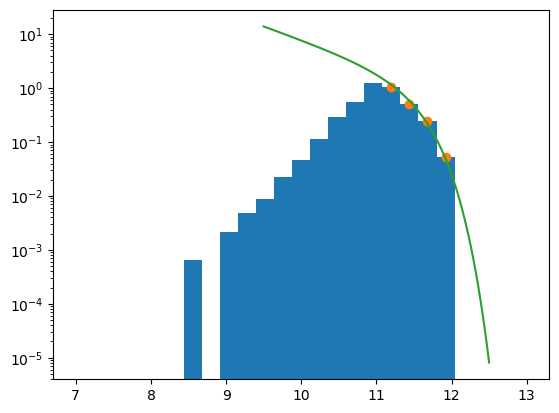

In [210]:
n, bins, _ = plt.hist(mass_list[15], weights = weight_list[15], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[16])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")

popt, pcov = curve_fit(schechter_fit_2, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[15] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_2(10**m, *popt), "-")
plt.show()

/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


[11.68699327 11.46254773]
[array([10.24217541, 11.46254773]) array([10.5582347 , 11.46254773])
 array([10.31209011, 11.462398  ]) array([10.76445975, 11.46254771])
 array([10.99107627, 11.46254773]) array([10.8974015 , 11.46254773])
 array([10.97125284, 11.46254773]) array([11.00170981, 11.46254773])
 array([11.19086503, 11.46254773]) array([11.2117798 , 11.46254773])
 array([11.29026067, 11.46254773]) array([11.37592114, 11.46254773])
 array([11.40453165, 11.46254772]) array([11.50395787, 11.46254771])
 array([11.60912616, 11.46254773]) array([11.62735961, 11.46254773])
 array([11.68699327, 11.46254773]) None None None None None]


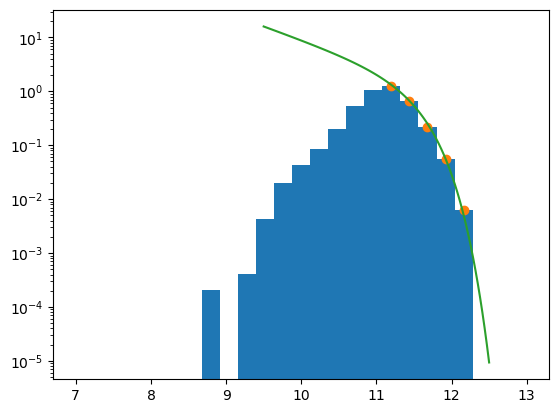

In [211]:
n, bins, _ = plt.hist(mass_list[16], weights = weight_list[16], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[17])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")

popt, pcov = curve_fit(schechter_fit_2, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[16] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_2(10**m, *popt), "-")
plt.show()

In [212]:
peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]

/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


array([1.24393556, 0.66460517, 0.22084513, 0.05588396, 0.00620933])

/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


[11.6600354 11.462398 ]
[array([10.24217541, 11.46254773]) array([10.5582347 , 11.46254773])
 array([10.31209011, 11.462398  ]) array([10.76445975, 11.46254771])
 array([10.99107627, 11.46254773]) array([10.8974015 , 11.46254773])
 array([10.97125284, 11.46254773]) array([11.00170981, 11.46254773])
 array([11.19086503, 11.46254773]) array([11.2117798 , 11.46254773])
 array([11.29026067, 11.46254773]) array([11.37592114, 11.46254773])
 array([11.40453165, 11.46254772]) array([11.50395787, 11.46254771])
 array([11.60912616, 11.46254773]) array([11.62735961, 11.46254773])
 array([11.68699327, 11.46254773]) array([11.6600354, 11.462398 ]) None
 None None None]


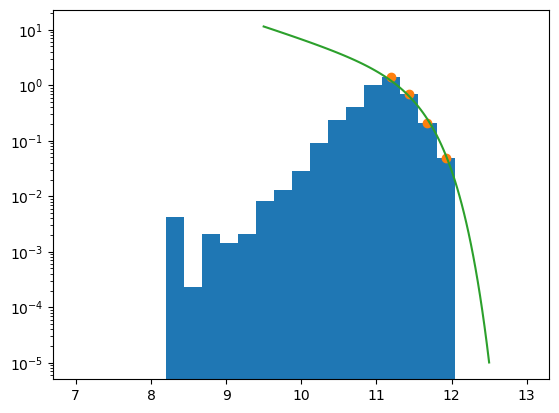

In [213]:
n, bins, _ = plt.hist(mass_list[17], weights = weight_list[17], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[18])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")

popt, pcov = curve_fit(schechter_fit_3, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[17] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_3(10**m, *popt), "-")
plt.show()

/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


[11.54437413 11.462398  ]
[array([10.24217541, 11.46254773]) array([10.5582347 , 11.46254773])
 array([10.31209011, 11.462398  ]) array([10.76445975, 11.46254771])
 array([10.99107627, 11.46254773]) array([10.8974015 , 11.46254773])
 array([10.97125284, 11.46254773]) array([11.00170981, 11.46254773])
 array([11.19086503, 11.46254773]) array([11.2117798 , 11.46254773])
 array([11.29026067, 11.46254773]) array([11.37592114, 11.46254773])
 array([11.40453165, 11.46254772]) array([11.50395787, 11.46254771])
 array([11.60912616, 11.46254773]) array([11.62735961, 11.46254773])
 array([11.68699327, 11.46254773]) array([11.6600354, 11.462398 ])
 array([11.54437413, 11.462398  ]) None None None]


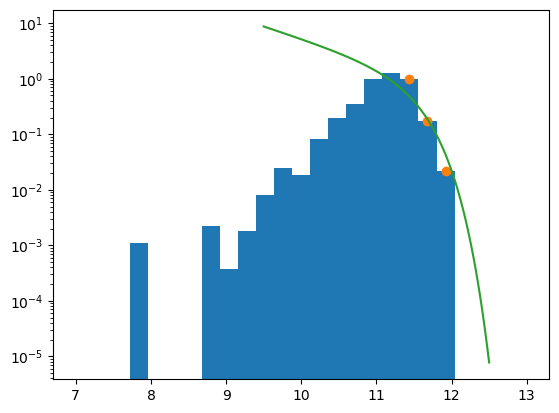

In [214]:
n, bins, _ = plt.hist(mass_list[18], weights = weight_list[18], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[19])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")

popt, pcov = curve_fit(schechter_fit_3, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[18] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_3(10**m, *popt), "-")
plt.show()

/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


[11.64995507 11.462398  ]
[array([10.24217541, 11.46254773]) array([10.5582347 , 11.46254773])
 array([10.31209011, 11.462398  ]) array([10.76445975, 11.46254771])
 array([10.99107627, 11.46254773]) array([10.8974015 , 11.46254773])
 array([10.97125284, 11.46254773]) array([11.00170981, 11.46254773])
 array([11.19086503, 11.46254773]) array([11.2117798 , 11.46254773])
 array([11.29026067, 11.46254773]) array([11.37592114, 11.46254773])
 array([11.40453165, 11.46254772]) array([11.50395787, 11.46254771])
 array([11.60912616, 11.46254773]) array([11.62735961, 11.46254773])
 array([11.68699327, 11.46254773]) array([11.6600354, 11.462398 ])
 array([11.54437413, 11.462398  ]) array([11.64995507, 11.462398  ]) None
 None]


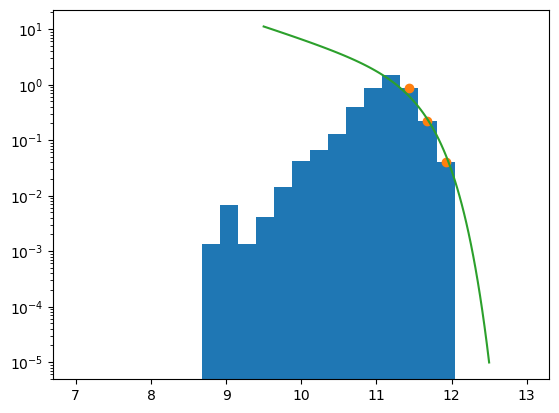

In [215]:
n, bins, _ = plt.hist(mass_list[19], weights = weight_list[19], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[20])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")

popt, pcov = curve_fit(schechter_fit_3, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[19] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_3(10**m, *popt), "-")
plt.show()

/home/mjb299/.conda/envs/dask/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


[11.67664478 11.462398  ]
[array([10.24217541, 11.46254773]) array([10.5582347 , 11.46254773])
 array([10.31209011, 11.462398  ]) array([10.76445975, 11.46254771])
 array([10.99107627, 11.46254773]) array([10.8974015 , 11.46254773])
 array([10.97125284, 11.46254773]) array([11.00170981, 11.46254773])
 array([11.19086503, 11.46254773]) array([11.2117798 , 11.46254773])
 array([11.29026067, 11.46254773]) array([11.37592114, 11.46254773])
 array([11.40453165, 11.46254772]) array([11.50395787, 11.46254771])
 array([11.60912616, 11.46254773]) array([11.62735961, 11.46254773])
 array([11.68699327, 11.46254773]) array([11.6600354, 11.462398 ])
 array([11.54437413, 11.462398  ]) array([11.64995507, 11.462398  ])
 array([11.67664478, 11.462398  ]) None]


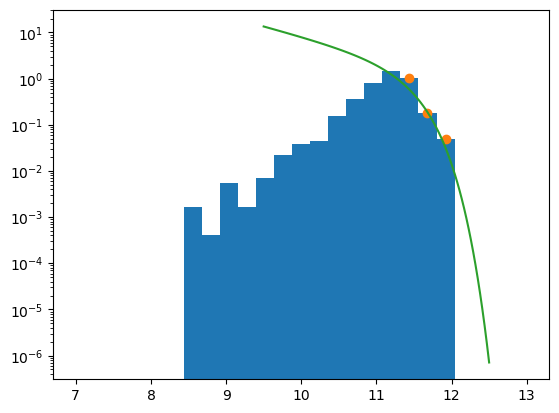

In [216]:
n, bins, _ = plt.hist(mass_list[20], weights = weight_list[20], bins= np.linspace(7, 13, 26), log = True, density = True)
peaks = np.array([n, (bins[1:] + bins[:-1])/2])
threshold = len(peaks[1][peaks[1] > mass_lim(bins_z[21])])
plt.plot(peaks[1][-threshold:], peaks[0][-threshold:], "o")

popt, pcov = curve_fit(schechter_fit_3, 10**peaks[1][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))], np.log10(peaks[0][-threshold:][np.isfinite(np.log10(peaks[0][-threshold:]))]), p0 = np.log10((2.9e10, 2.90e+11)), bounds = ((1, np.log10(2.9e11)), (15, np.log10(2.901e11))))
print(popt)
phi_mstar[20] = popt
print(phi_mstar)
m = np.linspace(9.5, 12.5, 100)
plt.semilogy(m, 10**schechter_fit_3(10**m, *popt+(0, -0.1)), "-")
plt.show()

In [217]:
PhiMstar = 10**np.stack(phi_mstar[:-1], axis = 1)

In [218]:
PhiMstar

array([[1.74652745e+10, 3.61605230e+10, 2.05158781e+10, 5.81379545e+10,
        9.79662020e+10, 7.89589752e+10, 9.35950416e+10, 1.00394475e+11,
        1.55190462e+11, 1.62847016e+11, 1.95101530e+11, 2.37640872e+11,
        2.53823393e+11, 3.19122829e+11, 4.06561414e+11, 4.23993901e+11,
        4.86399672e+11, 4.57125444e+11, 3.50246760e+11, 4.46637383e+11,
        4.74946594e+11],
       [2.90100000e+11, 2.90100000e+11, 2.90000000e+11, 2.90099984e+11,
        2.90100000e+11, 2.90100000e+11, 2.90100000e+11, 2.90100000e+11,
        2.90100000e+11, 2.90100000e+11, 2.90100000e+11, 2.90099999e+11,
        2.90099997e+11, 2.90099989e+11, 2.90100000e+11, 2.90100000e+11,
        2.90100000e+11, 2.90000000e+11, 2.90000000e+11, 2.90000000e+11,
        2.90000000e+11]])

In [3]:
PhiMstar = np.array([[2.48873739e+10, 5.36466650e+10, 5.21889518e+10, 7.09758021e+10,\
        1.06199280e+11, 9.43638107e+10, 1.12431094e+11, 1.09975655e+11,\
        1.58462481e+11, 1.62982236e+11, 1.90448954e+11, 2.50460633e+11,\
        2.39701030e+11, 2.80637641e+11, 3.85420217e+11, 4.11182169e+11,\
        4.40773131e+11, 3.91911693e+11, 3.22123901e+11, 3.52441707e+11,\
        3.67854893e+11],\
       [2.90000000e+11, 2.90100000e+11, 2.90000000e+11, 2.90000000e+11,\
        2.90100000e+11, 2.90000000e+11, 2.90000000e+11, 2.90000000e+11,\
        2.90100000e+11, 2.90100000e+11, 2.90000000e+11, 2.90000000e+11,\
        2.90000000e+11, 2.90000000e+11, 2.90100000e+11, 2.90000000e+11,\
        2.90000000e+11, 2.90000000e+11, 2.90000000e+11, 2.90000000e+11,\
        2.90000000e+11]])

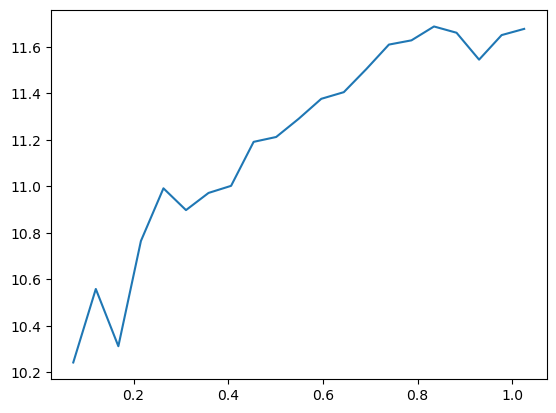

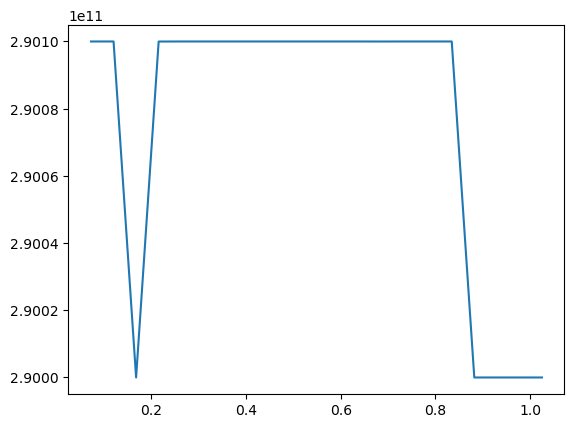

In [219]:
plt.plot(bins_z[1:], np.log10(PhiMstar[0]), "-")
plt.show()
plt.plot(bins_z[1:], PhiMstar[1], "-")
plt.show()

In [220]:
from scipy.special import gammaincc

In [10]:
alpha = -4.58821575e-01
m0 = 8
total_mass = np.zeros(21)
high_mass = np.zeros(21)
for i in range(0, 20):
    total_mass[i] = gammaincc(alpha+1, 10**(m0)/2.9e11)
    high_mass[i] = gammaincc(alpha+1, 10**(mass_lim(bins_z[i+1] + 0.2))/2.9e11)

In [250]:
total_mass = np.zeros(21)
high_mass = np.zeros(21)
m0 = 10
for i in range(0, 10):
    alpha = -7.53498308e-01
    total_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][i])
    high_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(mass_limit(bins_z[i+1]))/PhiMstar[1][i])
for i in range(10, 17):
    alpha = -5.01475038e-01
    total_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][i])
    high_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(mass_limit(bins_z[i+1]))/PhiMstar[1][i])
for i in range(17, 21):
    alpha = -4.40950237e-01
    total_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][i])
    high_mass[i] = PhiMstar[0][i]*gammaincc(alpha+1, 10**(mass_limit(bins_z[i+1]))/PhiMstar[1][i])

In [158]:
alpha = -4.58821575e-01
m0 = 8
total_mass = np.zeros(21)
total_mass[0] = PhiMstar[0][0]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][0])
total_mass[1] = PhiMstar[0][1]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][1])
total_mass[2] = PhiMstar[0][2]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][2])
total_mass[3] = PhiMstar[0][3]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][3])
total_mass[4] = PhiMstar[0][4]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][4])
total_mass[5] = PhiMstar[0][5]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][5])
total_mass[6] = PhiMstar[0][6]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][6])
total_mass[7] = PhiMstar[0][7]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][7])
total_mass[8] = PhiMstar[0][8]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][8])
total_mass[9] = PhiMstar[0][9]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][9])
total_mass[10] = PhiMstar[0][10]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][10])
total_mass[11] = PhiMstar[0][11]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][11])
total_mass[12] = PhiMstar[0][12]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][12])
total_mass[13] = PhiMstar[0][13]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][13])
total_mass[14] = PhiMstar[0][14]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][14])
total_mass[15] = PhiMstar[0][15]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][15])
total_mass[16] = PhiMstar[0][16]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][16])
total_mass[17] = PhiMstar[0][17]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][17])
total_mass[18] = PhiMstar[0][18]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][18])
total_mass[19] = PhiMstar[0][19]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][19])
total_mass[20] = PhiMstar[0][20]*gammaincc(alpha+1, 10**(m0)/PhiMstar[1][20])

high_mass = np.zeros(21)
high_mass[0] = PhiMstar[0][0]*gammaincc(alpha+1, 10**(mass_lim(bins_z[1] + 0.2))/PhiMstar[1][0])
high_mass[1] = PhiMstar[0][1]*gammaincc(alpha+1, 10**(mass_lim(bins_z[2] + 0.2))/PhiMstar[1][1])
high_mass[2] = PhiMstar[0][2]*gammaincc(alpha+1, 10**(mass_lim(bins_z[3] + 0.2))/PhiMstar[1][2])
high_mass[3] = PhiMstar[0][3]*gammaincc(alpha+1, 10**(mass_lim(bins_z[4] + 0.2))/PhiMstar[1][3])
high_mass[4] = PhiMstar[0][4]*gammaincc(alpha+1, 10**(mass_lim(bins_z[5] + 0.2))/PhiMstar[1][4])
high_mass[5] = PhiMstar[0][5]*gammaincc(alpha+1, 10**(mass_lim(bins_z[6] + 0.2))/PhiMstar[1][5])
high_mass[6] = PhiMstar[0][6]*gammaincc(alpha+1, 10**(mass_lim(bins_z[7] + 0.2))/PhiMstar[1][6])
high_mass[7] = PhiMstar[0][7]*gammaincc(alpha+1, 10**(mass_lim(bins_z[8] + 0.2))/PhiMstar[1][7])
high_mass[8] = PhiMstar[0][8]*gammaincc(alpha+1, 10**(mass_lim(bins_z[9] + 0.2))/PhiMstar[1][8])
high_mass[9] = PhiMstar[0][9]*gammaincc(alpha+1, 10**(mass_lim(bins_z[10] + 0.2))/PhiMstar[1][9])
high_mass[10] = PhiMstar[0][10]*gammaincc(alpha+1, 10**(mass_lim(bins_z[11] + 0.2))/PhiMstar[1][10])
high_mass[11] = PhiMstar[0][11]*gammaincc(alpha+1, 10**(mass_lim(bins_z[12] + 0.2))/PhiMstar[1][11])
high_mass[12] = PhiMstar[0][12]*gammaincc(alpha+1, 10**(mass_lim(bins_z[13] + 0.2))/PhiMstar[1][12])
high_mass[13] = PhiMstar[0][13]*gammaincc(alpha+1, 10**(mass_lim(bins_z[14] + 0.2))/PhiMstar[1][13])
high_mass[14] = PhiMstar[0][14]*gammaincc(alpha+1, 10**(mass_lim(bins_z[15] + 0.2))/PhiMstar[1][14])
high_mass[15] = PhiMstar[0][15]*gammaincc(alpha+1, 10**(mass_lim(bins_z[16] + 0.2))/PhiMstar[1][15])
high_mass[16] = PhiMstar[0][16]*gammaincc(alpha+1, 10**(mass_lim(bins_z[17] + 0.2))/PhiMstar[1][16])
high_mass[17] = PhiMstar[0][17]*gammaincc(alpha+1, 10**(mass_lim(bins_z[18] + 0.2))/PhiMstar[1][17])
high_mass[18] = PhiMstar[0][18]*gammaincc(alpha+1, 10**(mass_lim(bins_z[19] + 0.2))/PhiMstar[1][18])
high_mass[19] = PhiMstar[0][19]*gammaincc(alpha+1, 10**(mass_lim(bins_z[20] + 0.2))/PhiMstar[1][19])
high_mass[20] = PhiMstar[0][20]*gammaincc(alpha+1, 10**(mass_lim(bins_z[21] + 0.2))/PhiMstar[1][20])

In [251]:
mass_coeff = total_mass/high_mass

In [252]:
mass_limit(bins_z[20])

11.2

In [253]:
@np.vectorize
def quadratic(x, a, b, c):
    return a*x**2 + b*x + c

In [254]:
mass_coeff[-2]

2.501730405738856

In [255]:
mass_coeff[:-3]

array([1.0420432 , 1.08027488, 1.12270616, 1.16992564, 1.22277386,
       1.28217654, 1.34928788, 1.42552752, 1.51265614, 1.61287692,
       1.44631369, 1.53037109, 1.62917914, 1.74626445, 1.88624946,
       2.05527622, 2.2616274 , 2.35210337])

[0.18207414 0.23708011 0.00921863]


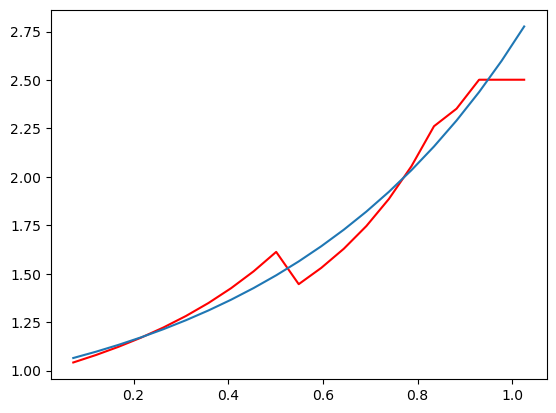

In [256]:
plt.plot(bins_z[1:], mass_coeff, "-r")
popt, pcov = curve_fit(quadratic, bins_z[1:-3], np.log10(mass_coeff[:-3]), p0 = (1, 1, 0)) #NOTE!!! -3 because mass limit of 11.2 reached at -3
print(popt)
plt.plot(bins_z[1:], 10**quadratic(bins_z[1:], *popt))
plt.show()

In [231]:
@np.vectorize
def mass_coeffficient(z):
    return np.exp((1.04935943)*z**2 + 0.39573094*z + 0.28347756) #Original

In [232]:
@np.vectorize
def mass_coeffficient_2(z):
    return np.exp((-0.08149478)*z**2 + 1.27502592*z + 0.16159883) #Improperly done, ignore

In [233]:
@np.vectorize
def mass_coeffficient_3(z):
    return np.exp((0.21929259)*z**2 + 0.40778932*z + -0.00783914) #No stars, 3 schechter

In [234]:
@np.vectorize
def mass_coeffficient_4(z):
    return np.exp((0.60355056)*z**2 + 0.10731729*z + 0.03417445) #Last schechter kept same as second

In [235]:
@np.vectorize
def mass_coeffficient_5(z):
    return np.exp((1.070815)*z**2 + -0.01536307*z + 0.03356501) #Fiddling with fits

In [236]:
@np.vectorize
def mass_coeffficient_6(z):
    return np.exp((1.07075801)*z**2 + -0.0152473*z + 0.03354483) #Fiddling with fits

In [257]:
@np.vectorize
def mass_coeffficient_7(z):
    return 10**((0.18207414)*z**2 + 0.23708011*z + 0.00921863) #COSMOS 2020

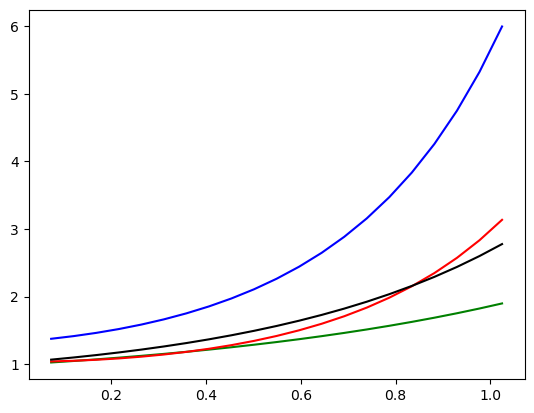

In [258]:
plt.plot(bins_z[1:], mass_coeffficient(bins_z[1:]), "b-")
plt.plot(bins_z[1:], mass_coeffficient_3(bins_z[1:]), "g-")
plt.plot(bins_z[1:], mass_coeffficient_5(bins_z[1:]), "r-")
plt.plot(bins_z[1:], mass_coeffficient_7(bins_z[1:]), "k-")

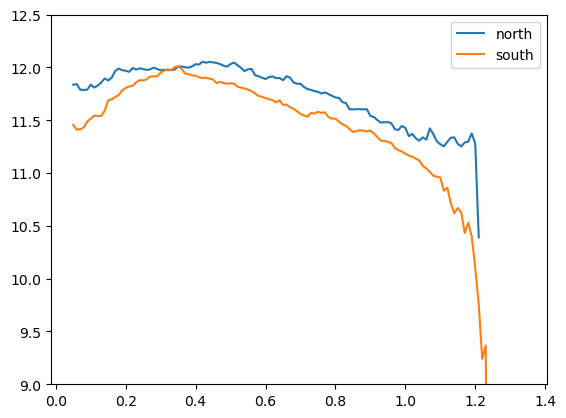

In [259]:
pd_north = pd.read_csv("north_mass_background_no_star.csv")
pd_south = pd.read_csv("south_mass_background_no_star.csv")
plt.plot(pd_north.z, pd_north["1mpcbkgd"], label = "north")
plt.plot(pd_south.z, pd_south["1mpcbkgd"], label = "south")
plt.legend()
plt.ylim(9, 12.5)
plt.show()

In [260]:
back_south_interp = interp1d(pd_south.z, pd_south["1mpcbkgd"], kind = "linear", fill_value = "extrapolate")

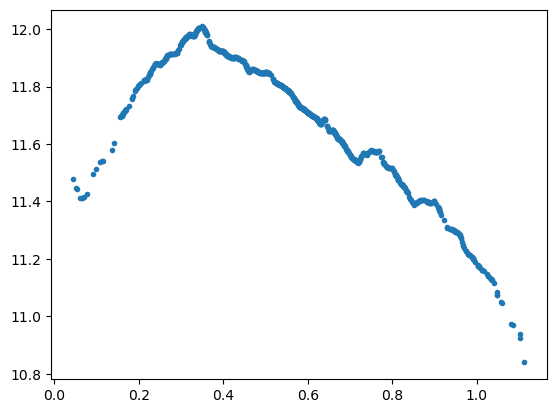

In [261]:
plt.plot(cluster_center.z_phot_median, back_south_interp(cluster_center.z_phot_median), ".")

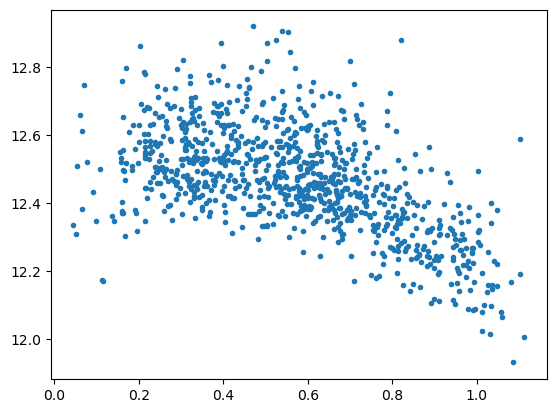

In [262]:
plt.plot(cluster_center.z_phot_median, cluster_center.neighbor_mass ,".")

In [226]:
np.mean(np.log10(10**cluster_center.neighbor_mass - 10**back_south_interp(cluster_center.z_phot_median)))

12.37974639569098

In [227]:
np.mean(cluster_center.neighbor_mass)

12.468926129594289

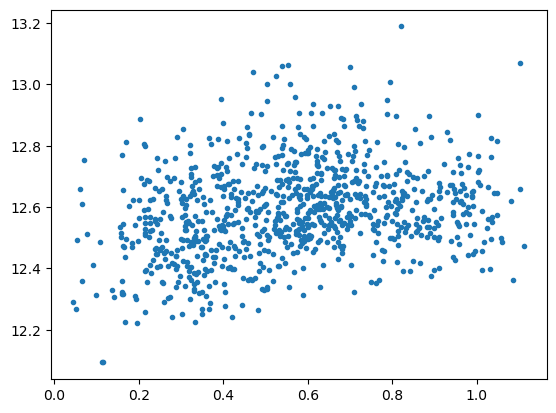

In [263]:
plt.plot(cluster_center.z_phot_median, np.log10(mass_coeffficient_7(cluster_center.z_phot_median)*(10**cluster_center.neighbor_mass - 10**back_south_interp(cluster_center.z_phot_median))),".")

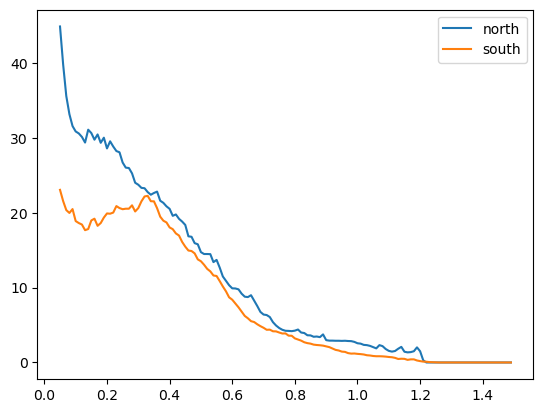

In [433]:
pd_north = pd.read_csv("north_background_no_star.csv")
pd_south = pd.read_csv("south_background_no_star.csv")
plt.plot(pd_north.z, pd_north["1mpcbkgd"], label = "north")
plt.plot(pd_south.z, pd_south["1mpcbkgd"], label = "south")
plt.legend()
#plt.ylim(9, 12.5)
plt.show()

In [441]:
back_interp = interp1d(pd_south.z, pd_south["halfmpcbkgd"], kind = "linear", fill_value = "extrapolate")

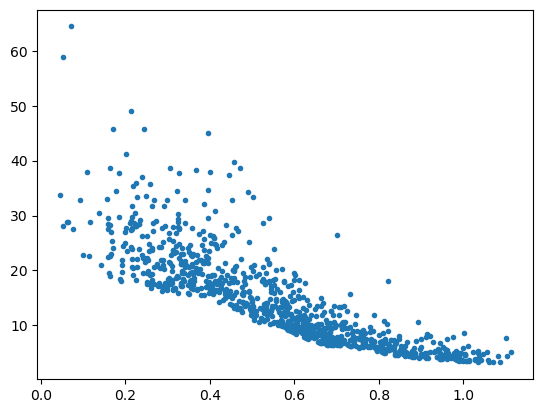

In [442]:
plt.plot(cluster_center.z_phot_median, cluster_center.local_neighbors ,".")

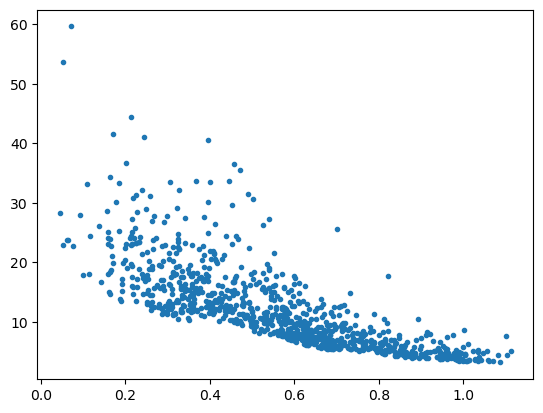

In [443]:
plt.plot(cluster_center.z_phot_median, cluster_center.local_neighbors - back_interp(cluster_center.z_phot_median),".")

## Lists for viewer

In [70]:
cluster_center[["RA", "DEC", "z_phot_median"]].head(60)

,RA,DEC,z_phot_median
1,6.804988,-4.940961,0.700436
2,9.865899,-4.779819,0.395547
3,3.725458,-0.952329,0.525973
16,1.730228,-0.693674,0.539584
6,8.719883,-3.043524,0.470578
10,6.750347,-4.223251,0.502474
11,5.554355,-0.609385,0.820839
59,2.093495,-0.657698,0.557179
13,7.870227,-1.733480,0.552639
37,3.359049,-4.833381,0.569424


In [49]:
cluster_center[np.logical_and(np.round(cluster_center.RA, 2) == 0.41, np.round(cluster_center.DEC, 2) == -3.88)].transpose()

,702
z_phot_median,0.754339
z_phot_std,0.0136763
mass,11.8362
RELEASE,8000
BRICKID,307337
BRICKNAME,0003m040
OBJID,7818
TYPE,DEV
RA,0.410861
DEC,-3.87749


In [50]:
cluster_center[np.logical_and(np.round(cluster_center.RA, 2) == 0.42, np.round(cluster_center.DEC, 2) == -3.88)].transpose()

,2494
z_phot_median,0.909823
z_phot_std,0.054489
mass,11.2548
RELEASE,8000
BRICKID,307337
BRICKNAME,0003m040
OBJID,7911
TYPE,DEV
RA,0.417819
DEC,-3.87741


# Crossmatching

In [51]:
redmapper = fits.open("Data/redmapper_dr8_public_v6.3_catalog.fits.gz")
redmapper.info()
redmap = redmapper[1]
from astropy.table import Table
dat = Table.read('Data/redmapper_dr8_public_v6.3_catalog.fits.gz', format='fits')
dat.remove_columns(["P_CEN", "RA_CEN", "DEC_CEN", "ID_CEN", "PZBINS", "PZ"])
df = dat.to_pandas()

Filename: Data/redmapper_dr8_public_v6.3_catalog.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     77   26111R x 30C   [J, 20A, D, D, E, E, E, E, E, E, K, E, E, E, E, E, E, E, E, E, E, E, E, E, 5E, 5E, 5E, 5K, 21E, 21E]   


In [52]:
c = SkyCoord(ra=cluster_center.RA.to_numpy()*u.degree, dec=cluster_center.DEC.to_numpy()*u.degree)
catalog = SkyCoord(ra=df.RA.to_numpy()*u.degree, dec=df.DEC.to_numpy()*u.degree)

max_sep = 5.0 * u.arcmin
idx, d2d, d3d = c.match_to_catalog_sky(catalog)
sep_constraint = d2d < max_sep
c_matches = c[sep_constraint]
catalog_matches = catalog[idx[sep_constraint]]

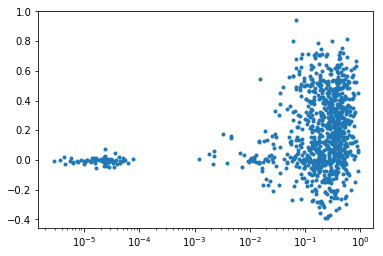

In [53]:
plt.semilogx(d2d.value, cluster_center.z_phot_median.to_numpy()-df.iloc[idx].Z_LAMBDA.to_numpy(), ".")
plt.show()

In [54]:
len(cluster_center[cluster_center.z_phot_median < 0.55])

443

In [55]:
len(cluster_center[np.logical_and(np.logical_and(d2d.value > 1e-2, np.abs(cluster_center.z_phot_median.to_numpy()-df.iloc[idx].Z_LAMBDA.to_numpy()) > 0.00), cluster_center.z_phot_median < 0.5)][["RA", "DEC", "z_phot_median", "mass", "local_neighbor_mass"]])

309

In [56]:
dfr = df[np.logical_and(np.logical_and(df.RA<cluster_center.RA.max(), df.RA>cluster_center.RA.min()), np.logical_and(df.DEC<cluster_center.DEC.max(), df.DEC>cluster_center.DEC.min()))]
max_sep = 5.0 * u.arcmin
catalog = SkyCoord(ra=dfr.RA.to_numpy()*u.degree, dec=dfr.DEC.to_numpy()*u.degree)
idx, d2d, d3d = catalog.match_to_catalog_sky(c)
sep_constraint = d2d < max_sep
catalog_matches = catalog[sep_constraint]
c_matches = c[idx[sep_constraint]]

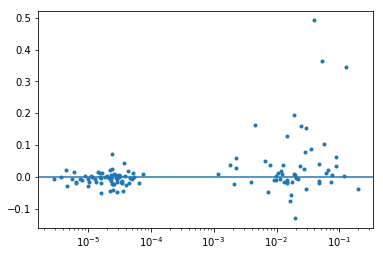

In [57]:
plt.semilogx(d2d.value, cluster_center.iloc[idx].z_phot_median.to_numpy()-dfr.Z_LAMBDA.to_numpy(), ".")
plt.axhline(0)
plt.show()

[]

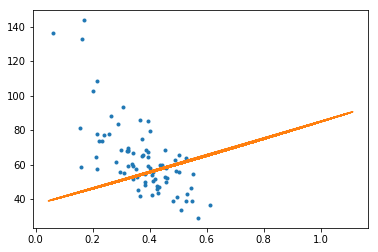

In [58]:
plt.plot(cluster_center.iloc[idx][d2d.value < 10e-3].z_phot_median, cluster_center.iloc[idx][d2d.value < 10e-3].neighbors, ".")
plt.plot(cluster_center.z_phot_median, (2*(1 + cluster_center.z_phot_median)**1.2*np.median(cluster_center.neighbors))/(1 + 0.5)**1.2)
plt.plot()

In [59]:
cluster_center.iloc[idx][np.logical_and(d2d.value > 1e-2, np.abs(cluster_center.iloc[idx].z_phot_median.to_numpy()-dfr.Z_LAMBDA.to_numpy()) > 0.1)][["RA", "DEC", "z_phot_median", "mass", "local_neighbor_mass"]].head(60)

,RA,DEC,z_phot_median,mass,local_neighbor_mass
2392,1.909043,-3.732939,0.743842,11.252232,11.994575
1484,7.079611,-2.542645,0.540162,11.259544,12.201780
286,7.165872,-2.613379,0.253965,11.718165,12.428108
1648,5.027015,-4.732049,0.544332,11.435161,12.177110
898,8.671347,-1.970504,0.322315,11.517843,12.294542
2331,8.322156,-0.479610,0.574869,11.372211,12.022066
2377,2.750671,-1.006892,0.607316,11.233842,12.001653
1488,9.284121,-2.086818,0.676149,11.349512,12.201250
1250,8.946741,-2.839486,0.802279,11.376121,12.239980


In [60]:
dfr[np.logical_and(d2d.value > 1e-2, np.abs(cluster_center.iloc[idx].z_phot_median.to_numpy()-dfr.Z_LAMBDA.to_numpy()) > 0.1)][["RA", "DEC", "Z_LAMBDA"]].head(60)

,RA,DEC,Z_LAMBDA
3864,1.927496,-3.767972,0.252415
4352,7.107742,-2.550961,0.387245
6548,7.175636,-2.630664,0.383463
6655,5.034800,-4.744568,0.416316
7310,8.621469,-1.998840,0.219074
16566,8.337504,-0.490938,0.380243
17877,2.770652,-1.021542,0.446531
20202,9.280182,-1.958092,0.331203
24501,8.941598,-2.786503,0.438626


In [148]:
len(dfr)

120

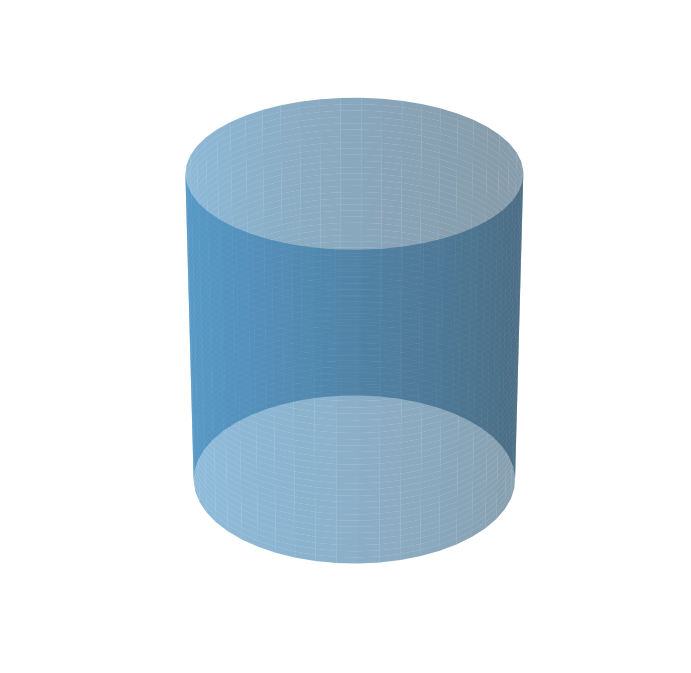

In [23]:
import numpy as np

def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(0, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (12, 12))
ax = fig.add_subplot(111, projection='3d')

Xc,Yc,Zc = data_for_cylinder_along_z(0.2,0.2,0.05,0.1)
ax.plot_surface(Xc, Yc, Zc, alpha=0.5)

plt.axis('off')
plt.show()